# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

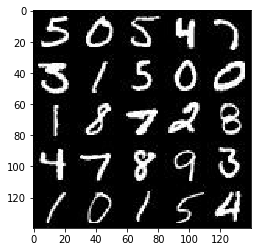

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

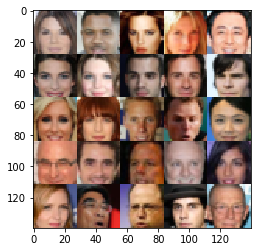

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        l1 = tf.layers.conv2d(images, 64, kernel_size=5, strides=2, padding="same")
        l1 = tf.maximum(alpha * l1, l1)
        # (14, 14, 64)
        
        l2 = tf.layers.conv2d(l1, 128, kernel_size=5, strides=2, padding="same")
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = tf.maximum(alpha * l2, l2)
        # (7, 7, 128)
        
        l3 = tf.layers.conv2d(l2, 256, kernel_size=5, strides=2, padding="same")
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = tf.maximum(alpha * l3, l3)
        # (4, 4, 256)
        
        flat = tf.reshape(l3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=False if is_train==True else True):
        l1 = tf.layers.dense(z, 2*2*512)
        l1 = tf.reshape(l1, (-1, 2, 2, 512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha*l1, l1)
        # (2, 2, 512)
        
        # out_height calculateion:
        # out_height = ceil(float(in_height * float(strides[1]) + filter_height - 1 * float(strides[1]))
        l2 = tf.layers.conv2d_transpose(l1, 256, kernel_size=4, strides=3, padding="valid")
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha*l2, l2)
        # (7, 7, 256)
        
        l3 = tf.layers.conv2d_transpose(l2, 128, kernel_size=5, strides=2, padding="same")
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(alpha*l3, l3)
        # (14, 14, 256)
        
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, kernel_size=5, strides=2, padding="same")
        # (28, 28, out_channel_dim)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim, is_train=True)
    
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_real)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    discriminator_variables = [var for var in variables if var.name.startswith("discriminator")]
    generator_variables = [var for var in variables if var.name.startswith("generator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_variables)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_variables)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    show_every = 100
    steps = 0

    number_examples, image_width, image_height, image_channel = data_shape
    # input placeholders
    input_real, input_z, learning_rate_placeholder = model_inputs(image_width, image_height, image_channel, z_dim)
    # losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channel)
    # train opts
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_placeholder, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # change the range from -0.5 to 0.5 as the outputs from tanh are in the range from -1 to 1
                batch_images = batch_images * 2
                # sample random noise for generator 
                batch_fake = np.random.uniform(-1, 1,size=(batch_size, z_dim))
                
                # run optimizers
                sess.run(d_train_opt, feed_dict={input_real:batch_images, input_z:batch_fake, learning_rate_placeholder:learning_rate})
                sess.run(g_train_opt, feed_dict={input_z:batch_fake, learning_rate_placeholder:learning_rate, input_real:batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    d_loss_value = d_loss.eval({input_z: batch_fake, input_real: batch_images})
                    g_loss_value = g_loss.eval({input_z: batch_fake, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}".format(steps),
                          "Discriminator Loss: {:.4f}...".format(d_loss_value),
                          "Generator Loss: {:.4f}".format(g_loss_value))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channel, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10 Discriminator Loss: 2.4858... Generator Loss: 19.6452
Epoch 1/2... Step 20 Discriminator Loss: 1.4247... Generator Loss: 0.6437
Epoch 1/2... Step 30 Discriminator Loss: 2.0276... Generator Loss: 6.3077
Epoch 1/2... Step 40 Discriminator Loss: 2.0010... Generator Loss: 6.8975
Epoch 1/2... Step 50 Discriminator Loss: 1.2266... Generator Loss: 1.1346
Epoch 1/2... Step 60 Discriminator Loss: 0.7367... Generator Loss: 1.5948
Epoch 1/2... Step 70 Discriminator Loss: 2.6705... Generator Loss: 0.1427
Epoch 1/2... Step 80 Discriminator Loss: 0.6714... Generator Loss: 3.3050
Epoch 1/2... Step 90 Discriminator Loss: 1.2537... Generator Loss: 0.6742
Epoch 1/2... Step 100 Discriminator Loss: 0.8573... Generator Loss: 1.9178


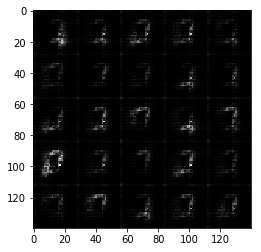

Epoch 1/2... Step 110 Discriminator Loss: 0.6845... Generator Loss: 1.8644
Epoch 1/2... Step 120 Discriminator Loss: 0.8419... Generator Loss: 3.3412
Epoch 1/2... Step 130 Discriminator Loss: 0.6768... Generator Loss: 3.8124
Epoch 1/2... Step 140 Discriminator Loss: 0.6087... Generator Loss: 2.4160
Epoch 1/2... Step 150 Discriminator Loss: 0.6037... Generator Loss: 1.8250
Epoch 1/2... Step 160 Discriminator Loss: 0.6244... Generator Loss: 1.7967
Epoch 1/2... Step 170 Discriminator Loss: 1.0026... Generator Loss: 1.5994
Epoch 1/2... Step 180 Discriminator Loss: 0.5437... Generator Loss: 2.4018
Epoch 1/2... Step 190 Discriminator Loss: 0.5000... Generator Loss: 2.4265
Epoch 1/2... Step 200 Discriminator Loss: 0.6559... Generator Loss: 3.4924


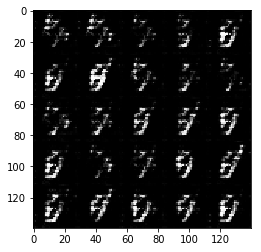

Epoch 1/2... Step 210 Discriminator Loss: 1.5383... Generator Loss: 0.5516
Epoch 1/2... Step 220 Discriminator Loss: 1.7218... Generator Loss: 0.3489
Epoch 1/2... Step 230 Discriminator Loss: 0.8772... Generator Loss: 1.1410
Epoch 1/2... Step 240 Discriminator Loss: 0.7181... Generator Loss: 2.3704
Epoch 1/2... Step 250 Discriminator Loss: 1.1368... Generator Loss: 0.9821
Epoch 1/2... Step 260 Discriminator Loss: 1.0888... Generator Loss: 2.0803
Epoch 1/2... Step 270 Discriminator Loss: 1.0968... Generator Loss: 3.5947
Epoch 1/2... Step 280 Discriminator Loss: 1.0382... Generator Loss: 2.1898
Epoch 1/2... Step 290 Discriminator Loss: 0.7131... Generator Loss: 2.2447
Epoch 1/2... Step 300 Discriminator Loss: 1.0344... Generator Loss: 1.8648


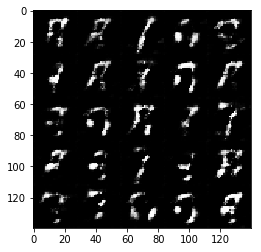

Epoch 1/2... Step 310 Discriminator Loss: 1.0937... Generator Loss: 0.9512
Epoch 1/2... Step 320 Discriminator Loss: 0.9241... Generator Loss: 2.1242
Epoch 1/2... Step 330 Discriminator Loss: 1.2176... Generator Loss: 0.9617
Epoch 1/2... Step 340 Discriminator Loss: 1.2376... Generator Loss: 0.6575
Epoch 1/2... Step 350 Discriminator Loss: 1.0988... Generator Loss: 0.8286
Epoch 1/2... Step 360 Discriminator Loss: 1.2789... Generator Loss: 3.0250
Epoch 1/2... Step 370 Discriminator Loss: 1.7137... Generator Loss: 0.3702
Epoch 1/2... Step 380 Discriminator Loss: 0.8776... Generator Loss: 1.5523
Epoch 1/2... Step 390 Discriminator Loss: 1.0871... Generator Loss: 0.8839
Epoch 1/2... Step 400 Discriminator Loss: 1.1010... Generator Loss: 1.8495


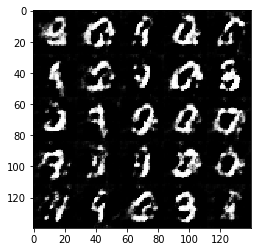

Epoch 1/2... Step 410 Discriminator Loss: 1.0033... Generator Loss: 1.7290
Epoch 1/2... Step 420 Discriminator Loss: 1.1456... Generator Loss: 0.8135
Epoch 1/2... Step 430 Discriminator Loss: 1.0111... Generator Loss: 1.5707
Epoch 1/2... Step 440 Discriminator Loss: 1.1749... Generator Loss: 2.5162
Epoch 1/2... Step 450 Discriminator Loss: 0.9897... Generator Loss: 1.0996
Epoch 1/2... Step 460 Discriminator Loss: 1.0803... Generator Loss: 1.9721
Epoch 1/2... Step 470 Discriminator Loss: 1.4247... Generator Loss: 2.4806
Epoch 1/2... Step 480 Discriminator Loss: 1.3200... Generator Loss: 1.6681
Epoch 1/2... Step 490 Discriminator Loss: 1.1115... Generator Loss: 0.7238
Epoch 1/2... Step 500 Discriminator Loss: 1.1489... Generator Loss: 0.7797


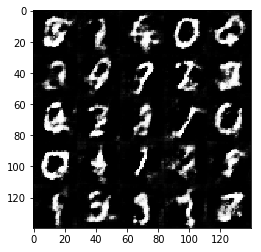

Epoch 1/2... Step 510 Discriminator Loss: 1.1017... Generator Loss: 1.2118
Epoch 1/2... Step 520 Discriminator Loss: 1.5371... Generator Loss: 0.4305
Epoch 1/2... Step 530 Discriminator Loss: 1.1786... Generator Loss: 0.7502
Epoch 1/2... Step 540 Discriminator Loss: 1.1733... Generator Loss: 0.7371
Epoch 1/2... Step 550 Discriminator Loss: 1.0781... Generator Loss: 0.8754
Epoch 1/2... Step 560 Discriminator Loss: 1.0684... Generator Loss: 1.5268
Epoch 1/2... Step 570 Discriminator Loss: 1.1802... Generator Loss: 1.7294
Epoch 1/2... Step 580 Discriminator Loss: 1.2969... Generator Loss: 1.7245
Epoch 1/2... Step 590 Discriminator Loss: 1.1718... Generator Loss: 2.2582
Epoch 1/2... Step 600 Discriminator Loss: 1.0304... Generator Loss: 1.7133


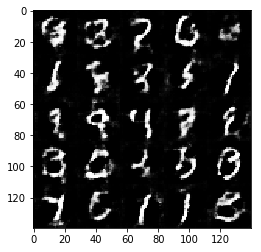

Epoch 1/2... Step 610 Discriminator Loss: 1.0496... Generator Loss: 1.0512
Epoch 1/2... Step 620 Discriminator Loss: 1.1275... Generator Loss: 0.9359
Epoch 1/2... Step 630 Discriminator Loss: 0.9398... Generator Loss: 1.1968
Epoch 1/2... Step 640 Discriminator Loss: 1.2493... Generator Loss: 1.6247
Epoch 1/2... Step 650 Discriminator Loss: 1.6537... Generator Loss: 0.4044
Epoch 1/2... Step 660 Discriminator Loss: 1.1570... Generator Loss: 1.5353
Epoch 1/2... Step 670 Discriminator Loss: 1.1187... Generator Loss: 1.0057
Epoch 1/2... Step 680 Discriminator Loss: 1.3681... Generator Loss: 0.4980
Epoch 1/2... Step 690 Discriminator Loss: 1.3630... Generator Loss: 1.5834
Epoch 1/2... Step 700 Discriminator Loss: 1.0171... Generator Loss: 1.0495


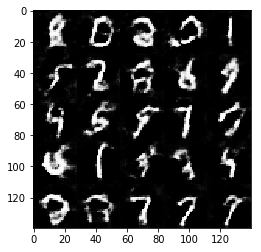

Epoch 1/2... Step 710 Discriminator Loss: 0.8877... Generator Loss: 1.0621
Epoch 1/2... Step 720 Discriminator Loss: 1.6483... Generator Loss: 0.3739
Epoch 1/2... Step 730 Discriminator Loss: 0.9758... Generator Loss: 1.0812
Epoch 1/2... Step 740 Discriminator Loss: 1.2615... Generator Loss: 0.5792
Epoch 1/2... Step 750 Discriminator Loss: 1.2621... Generator Loss: 2.2858
Epoch 1/2... Step 760 Discriminator Loss: 1.7294... Generator Loss: 0.3792
Epoch 1/2... Step 770 Discriminator Loss: 1.0857... Generator Loss: 0.8041
Epoch 1/2... Step 780 Discriminator Loss: 1.0346... Generator Loss: 0.8893
Epoch 1/2... Step 790 Discriminator Loss: 1.7499... Generator Loss: 0.3260
Epoch 1/2... Step 800 Discriminator Loss: 1.2265... Generator Loss: 0.6627


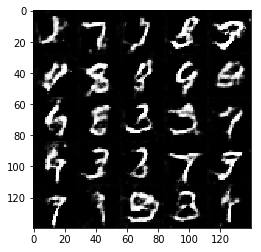

Epoch 1/2... Step 810 Discriminator Loss: 1.0839... Generator Loss: 1.0926
Epoch 1/2... Step 820 Discriminator Loss: 1.3036... Generator Loss: 2.0441
Epoch 1/2... Step 830 Discriminator Loss: 1.3360... Generator Loss: 0.5581
Epoch 1/2... Step 840 Discriminator Loss: 1.5302... Generator Loss: 0.4053
Epoch 1/2... Step 850 Discriminator Loss: 1.0706... Generator Loss: 0.8071
Epoch 1/2... Step 860 Discriminator Loss: 1.1237... Generator Loss: 1.6832
Epoch 1/2... Step 870 Discriminator Loss: 1.2015... Generator Loss: 1.9553
Epoch 1/2... Step 880 Discriminator Loss: 1.0339... Generator Loss: 0.8362
Epoch 1/2... Step 890 Discriminator Loss: 1.5337... Generator Loss: 0.4469
Epoch 1/2... Step 900 Discriminator Loss: 1.1993... Generator Loss: 1.7708


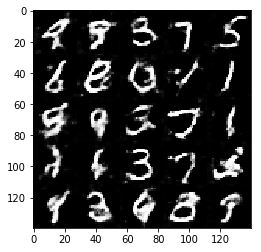

Epoch 1/2... Step 910 Discriminator Loss: 1.0988... Generator Loss: 0.9173
Epoch 1/2... Step 920 Discriminator Loss: 1.1231... Generator Loss: 1.5084
Epoch 1/2... Step 930 Discriminator Loss: 0.9750... Generator Loss: 1.3434
Epoch 1/2... Step 940 Discriminator Loss: 1.1844... Generator Loss: 0.6419
Epoch 1/2... Step 950 Discriminator Loss: 1.1280... Generator Loss: 0.7926
Epoch 1/2... Step 960 Discriminator Loss: 0.9430... Generator Loss: 1.2297
Epoch 1/2... Step 970 Discriminator Loss: 0.8975... Generator Loss: 1.6006
Epoch 1/2... Step 980 Discriminator Loss: 1.3628... Generator Loss: 0.5189
Epoch 1/2... Step 990 Discriminator Loss: 0.9867... Generator Loss: 0.9464
Epoch 1/2... Step 1000 Discriminator Loss: 1.3423... Generator Loss: 0.5751


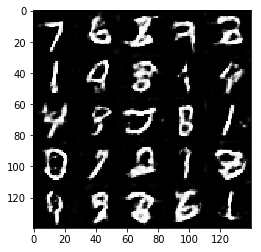

Epoch 1/2... Step 1010 Discriminator Loss: 1.0517... Generator Loss: 1.4714
Epoch 1/2... Step 1020 Discriminator Loss: 1.0028... Generator Loss: 1.0707
Epoch 1/2... Step 1030 Discriminator Loss: 0.9270... Generator Loss: 1.2120
Epoch 1/2... Step 1040 Discriminator Loss: 1.0185... Generator Loss: 1.0326
Epoch 1/2... Step 1050 Discriminator Loss: 1.1322... Generator Loss: 0.9522
Epoch 1/2... Step 1060 Discriminator Loss: 1.1682... Generator Loss: 0.7232
Epoch 1/2... Step 1070 Discriminator Loss: 1.7684... Generator Loss: 0.3858
Epoch 1/2... Step 1080 Discriminator Loss: 1.0537... Generator Loss: 0.8699
Epoch 1/2... Step 1090 Discriminator Loss: 0.9871... Generator Loss: 1.4519
Epoch 1/2... Step 1100 Discriminator Loss: 0.8844... Generator Loss: 1.1771


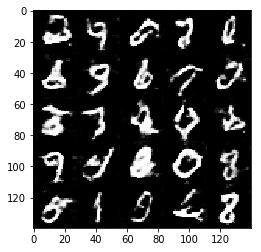

Epoch 1/2... Step 1110 Discriminator Loss: 1.4247... Generator Loss: 0.4806
Epoch 1/2... Step 1120 Discriminator Loss: 1.6718... Generator Loss: 0.3585
Epoch 1/2... Step 1130 Discriminator Loss: 0.8706... Generator Loss: 1.3481
Epoch 1/2... Step 1140 Discriminator Loss: 1.1439... Generator Loss: 0.7276
Epoch 1/2... Step 1150 Discriminator Loss: 1.2041... Generator Loss: 1.8010
Epoch 1/2... Step 1160 Discriminator Loss: 0.9349... Generator Loss: 1.4267
Epoch 1/2... Step 1170 Discriminator Loss: 2.2393... Generator Loss: 0.1847
Epoch 1/2... Step 1180 Discriminator Loss: 1.0754... Generator Loss: 0.7828
Epoch 1/2... Step 1190 Discriminator Loss: 0.8418... Generator Loss: 1.2003
Epoch 1/2... Step 1200 Discriminator Loss: 0.9254... Generator Loss: 1.4930


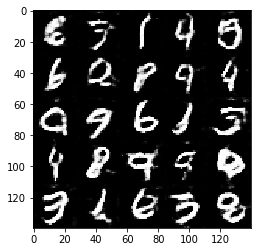

Epoch 1/2... Step 1210 Discriminator Loss: 1.1664... Generator Loss: 0.7401
Epoch 1/2... Step 1220 Discriminator Loss: 1.6128... Generator Loss: 0.4329
Epoch 1/2... Step 1230 Discriminator Loss: 0.9509... Generator Loss: 0.9793
Epoch 1/2... Step 1240 Discriminator Loss: 1.1565... Generator Loss: 1.1137
Epoch 1/2... Step 1250 Discriminator Loss: 1.0998... Generator Loss: 0.6887
Epoch 1/2... Step 1260 Discriminator Loss: 1.1758... Generator Loss: 0.7132
Epoch 1/2... Step 1270 Discriminator Loss: 0.8717... Generator Loss: 1.4321
Epoch 1/2... Step 1280 Discriminator Loss: 1.5240... Generator Loss: 0.5277
Epoch 1/2... Step 1290 Discriminator Loss: 0.9249... Generator Loss: 1.5810
Epoch 1/2... Step 1300 Discriminator Loss: 1.0583... Generator Loss: 1.3420


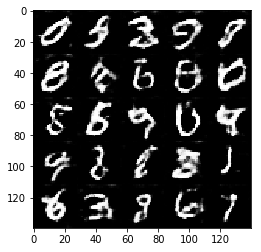

Epoch 1/2... Step 1310 Discriminator Loss: 0.9478... Generator Loss: 1.1638
Epoch 1/2... Step 1320 Discriminator Loss: 1.4350... Generator Loss: 0.4840
Epoch 1/2... Step 1330 Discriminator Loss: 0.9025... Generator Loss: 1.2192
Epoch 1/2... Step 1340 Discriminator Loss: 1.2683... Generator Loss: 0.5430
Epoch 1/2... Step 1350 Discriminator Loss: 1.2327... Generator Loss: 0.6260
Epoch 1/2... Step 1360 Discriminator Loss: 0.9740... Generator Loss: 1.3207
Epoch 1/2... Step 1370 Discriminator Loss: 0.8660... Generator Loss: 1.1762
Epoch 1/2... Step 1380 Discriminator Loss: 1.3026... Generator Loss: 0.5849
Epoch 1/2... Step 1390 Discriminator Loss: 1.1593... Generator Loss: 0.7973
Epoch 1/2... Step 1400 Discriminator Loss: 1.3594... Generator Loss: 0.5194


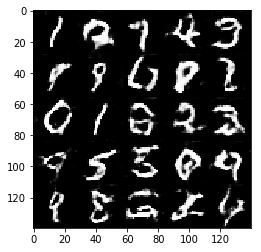

Epoch 1/2... Step 1410 Discriminator Loss: 1.5542... Generator Loss: 0.3964
Epoch 1/2... Step 1420 Discriminator Loss: 1.0363... Generator Loss: 2.1019
Epoch 1/2... Step 1430 Discriminator Loss: 1.1115... Generator Loss: 0.9686
Epoch 1/2... Step 1440 Discriminator Loss: 0.7991... Generator Loss: 1.6700
Epoch 1/2... Step 1450 Discriminator Loss: 1.0193... Generator Loss: 0.8710
Epoch 1/2... Step 1460 Discriminator Loss: 1.3523... Generator Loss: 0.5768
Epoch 1/2... Step 1470 Discriminator Loss: 0.8191... Generator Loss: 1.3804
Epoch 1/2... Step 1480 Discriminator Loss: 0.9799... Generator Loss: 1.1302
Epoch 1/2... Step 1490 Discriminator Loss: 0.9611... Generator Loss: 1.3912
Epoch 1/2... Step 1500 Discriminator Loss: 1.1415... Generator Loss: 0.7190


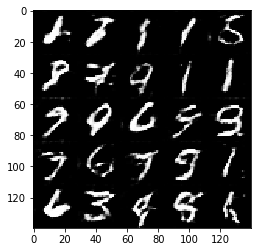

Epoch 1/2... Step 1510 Discriminator Loss: 1.5585... Generator Loss: 0.4808
Epoch 1/2... Step 1520 Discriminator Loss: 1.1719... Generator Loss: 0.7502
Epoch 1/2... Step 1530 Discriminator Loss: 0.9425... Generator Loss: 1.8161
Epoch 1/2... Step 1540 Discriminator Loss: 0.9936... Generator Loss: 1.1114
Epoch 1/2... Step 1550 Discriminator Loss: 1.1330... Generator Loss: 0.7223
Epoch 1/2... Step 1560 Discriminator Loss: 2.4997... Generator Loss: 4.4216
Epoch 1/2... Step 1570 Discriminator Loss: 0.8527... Generator Loss: 1.0879
Epoch 1/2... Step 1580 Discriminator Loss: 0.9393... Generator Loss: 1.9520
Epoch 1/2... Step 1590 Discriminator Loss: 0.8149... Generator Loss: 1.2765
Epoch 1/2... Step 1600 Discriminator Loss: 0.8937... Generator Loss: 1.5332


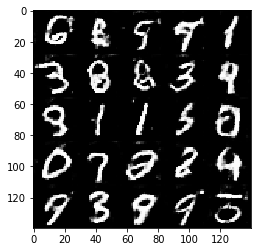

Epoch 1/2... Step 1610 Discriminator Loss: 0.7751... Generator Loss: 1.3911
Epoch 1/2... Step 1620 Discriminator Loss: 2.2085... Generator Loss: 0.2226
Epoch 1/2... Step 1630 Discriminator Loss: 1.2372... Generator Loss: 0.6657
Epoch 1/2... Step 1640 Discriminator Loss: 1.1615... Generator Loss: 0.7064
Epoch 1/2... Step 1650 Discriminator Loss: 1.2003... Generator Loss: 0.6791
Epoch 1/2... Step 1660 Discriminator Loss: 0.8160... Generator Loss: 1.1315
Epoch 1/2... Step 1670 Discriminator Loss: 0.8793... Generator Loss: 1.0549
Epoch 1/2... Step 1680 Discriminator Loss: 1.6348... Generator Loss: 0.4477
Epoch 1/2... Step 1690 Discriminator Loss: 0.5994... Generator Loss: 1.6983
Epoch 1/2... Step 1700 Discriminator Loss: 1.4104... Generator Loss: 0.4953


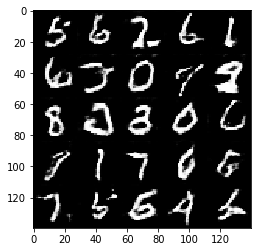

Epoch 1/2... Step 1710 Discriminator Loss: 1.3152... Generator Loss: 0.5486
Epoch 1/2... Step 1720 Discriminator Loss: 1.7218... Generator Loss: 0.3465
Epoch 1/2... Step 1730 Discriminator Loss: 1.0568... Generator Loss: 0.8417
Epoch 1/2... Step 1740 Discriminator Loss: 0.8306... Generator Loss: 1.1556
Epoch 1/2... Step 1750 Discriminator Loss: 0.8888... Generator Loss: 0.9454
Epoch 1/2... Step 1760 Discriminator Loss: 1.6204... Generator Loss: 0.3846
Epoch 1/2... Step 1770 Discriminator Loss: 0.9673... Generator Loss: 0.9633
Epoch 1/2... Step 1780 Discriminator Loss: 0.9713... Generator Loss: 2.7141
Epoch 1/2... Step 1790 Discriminator Loss: 1.0233... Generator Loss: 1.0373
Epoch 1/2... Step 1800 Discriminator Loss: 0.8634... Generator Loss: 1.7088


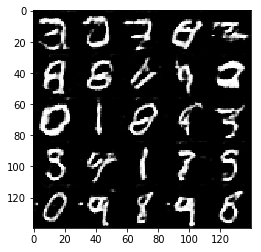

Epoch 1/2... Step 1810 Discriminator Loss: 1.4640... Generator Loss: 0.4346
Epoch 1/2... Step 1820 Discriminator Loss: 1.0794... Generator Loss: 2.7405
Epoch 1/2... Step 1830 Discriminator Loss: 1.3302... Generator Loss: 0.5646
Epoch 1/2... Step 1840 Discriminator Loss: 1.5582... Generator Loss: 0.4935
Epoch 1/2... Step 1850 Discriminator Loss: 1.0318... Generator Loss: 1.1704
Epoch 1/2... Step 1860 Discriminator Loss: 0.8362... Generator Loss: 1.7184
Epoch 1/2... Step 1870 Discriminator Loss: 0.7715... Generator Loss: 1.5189
Epoch 2/2... Step 1880 Discriminator Loss: 1.3667... Generator Loss: 2.6769
Epoch 2/2... Step 1890 Discriminator Loss: 0.6985... Generator Loss: 1.6347
Epoch 2/2... Step 1900 Discriminator Loss: 1.5800... Generator Loss: 0.3959


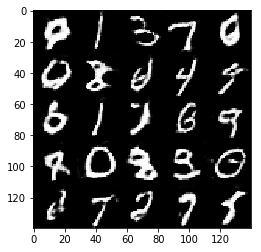

Epoch 2/2... Step 1910 Discriminator Loss: 1.5111... Generator Loss: 0.5000
Epoch 2/2... Step 1920 Discriminator Loss: 0.7343... Generator Loss: 1.7120
Epoch 2/2... Step 1930 Discriminator Loss: 0.9366... Generator Loss: 0.9385
Epoch 2/2... Step 1940 Discriminator Loss: 1.1974... Generator Loss: 0.6590
Epoch 2/2... Step 1950 Discriminator Loss: 1.3461... Generator Loss: 0.5458
Epoch 2/2... Step 1960 Discriminator Loss: 0.8616... Generator Loss: 1.0878
Epoch 2/2... Step 1970 Discriminator Loss: 0.6164... Generator Loss: 1.9720
Epoch 2/2... Step 1980 Discriminator Loss: 0.7028... Generator Loss: 1.6845
Epoch 2/2... Step 1990 Discriminator Loss: 0.7436... Generator Loss: 1.6155
Epoch 2/2... Step 2000 Discriminator Loss: 0.8634... Generator Loss: 1.0873


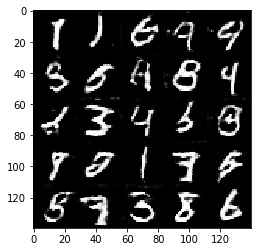

Epoch 2/2... Step 2010 Discriminator Loss: 2.1020... Generator Loss: 3.5737
Epoch 2/2... Step 2020 Discriminator Loss: 0.7369... Generator Loss: 1.8074
Epoch 2/2... Step 2030 Discriminator Loss: 1.7058... Generator Loss: 0.4014
Epoch 2/2... Step 2040 Discriminator Loss: 1.1769... Generator Loss: 0.6998
Epoch 2/2... Step 2050 Discriminator Loss: 0.7979... Generator Loss: 1.2110
Epoch 2/2... Step 2060 Discriminator Loss: 0.7573... Generator Loss: 1.5550
Epoch 2/2... Step 2070 Discriminator Loss: 0.9326... Generator Loss: 0.9568
Epoch 2/2... Step 2080 Discriminator Loss: 1.2198... Generator Loss: 0.6527
Epoch 2/2... Step 2090 Discriminator Loss: 0.9720... Generator Loss: 0.8855
Epoch 2/2... Step 2100 Discriminator Loss: 1.2436... Generator Loss: 0.6269


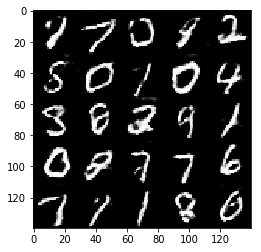

Epoch 2/2... Step 2110 Discriminator Loss: 0.8880... Generator Loss: 1.7425
Epoch 2/2... Step 2120 Discriminator Loss: 0.8865... Generator Loss: 1.2534
Epoch 2/2... Step 2130 Discriminator Loss: 1.1292... Generator Loss: 0.6978
Epoch 2/2... Step 2140 Discriminator Loss: 0.7253... Generator Loss: 2.1255
Epoch 2/2... Step 2150 Discriminator Loss: 0.8061... Generator Loss: 1.4289
Epoch 2/2... Step 2160 Discriminator Loss: 0.7950... Generator Loss: 1.3406
Epoch 2/2... Step 2170 Discriminator Loss: 1.2221... Generator Loss: 0.6066
Epoch 2/2... Step 2180 Discriminator Loss: 0.7269... Generator Loss: 1.6915
Epoch 2/2... Step 2190 Discriminator Loss: 1.4974... Generator Loss: 2.5003
Epoch 2/2... Step 2200 Discriminator Loss: 0.9410... Generator Loss: 1.2641


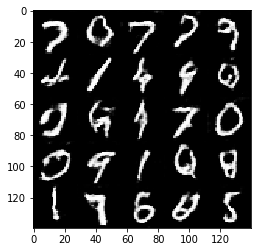

Epoch 2/2... Step 2210 Discriminator Loss: 1.1759... Generator Loss: 0.6702
Epoch 2/2... Step 2220 Discriminator Loss: 0.9898... Generator Loss: 0.8389
Epoch 2/2... Step 2230 Discriminator Loss: 0.8615... Generator Loss: 1.0644
Epoch 2/2... Step 2240 Discriminator Loss: 0.9192... Generator Loss: 1.0845
Epoch 2/2... Step 2250 Discriminator Loss: 0.9726... Generator Loss: 1.0539
Epoch 2/2... Step 2260 Discriminator Loss: 1.0111... Generator Loss: 1.7739
Epoch 2/2... Step 2270 Discriminator Loss: 2.0201... Generator Loss: 0.2986
Epoch 2/2... Step 2280 Discriminator Loss: 0.7799... Generator Loss: 1.7580
Epoch 2/2... Step 2290 Discriminator Loss: 0.9448... Generator Loss: 0.9267
Epoch 2/2... Step 2300 Discriminator Loss: 1.7750... Generator Loss: 0.3815


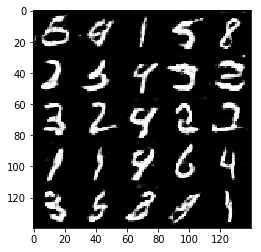

Epoch 2/2... Step 2310 Discriminator Loss: 2.0058... Generator Loss: 0.2697
Epoch 2/2... Step 2320 Discriminator Loss: 1.7732... Generator Loss: 0.4655
Epoch 2/2... Step 2330 Discriminator Loss: 1.1550... Generator Loss: 0.7298
Epoch 2/2... Step 2340 Discriminator Loss: 0.8558... Generator Loss: 1.0733
Epoch 2/2... Step 2350 Discriminator Loss: 1.6351... Generator Loss: 3.9840
Epoch 2/2... Step 2360 Discriminator Loss: 0.7885... Generator Loss: 1.1140
Epoch 2/2... Step 2370 Discriminator Loss: 1.5019... Generator Loss: 0.4816
Epoch 2/2... Step 2380 Discriminator Loss: 0.7483... Generator Loss: 1.4679
Epoch 2/2... Step 2390 Discriminator Loss: 0.7294... Generator Loss: 1.2932
Epoch 2/2... Step 2400 Discriminator Loss: 0.9808... Generator Loss: 3.1844


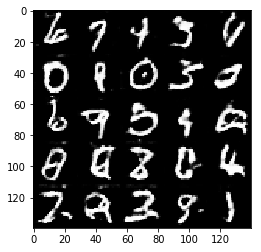

Epoch 2/2... Step 2410 Discriminator Loss: 1.3009... Generator Loss: 0.5535
Epoch 2/2... Step 2420 Discriminator Loss: 0.7612... Generator Loss: 1.7200
Epoch 2/2... Step 2430 Discriminator Loss: 0.7875... Generator Loss: 1.1651
Epoch 2/2... Step 2440 Discriminator Loss: 0.8594... Generator Loss: 1.1236
Epoch 2/2... Step 2450 Discriminator Loss: 0.8592... Generator Loss: 1.0654
Epoch 2/2... Step 2460 Discriminator Loss: 1.7228... Generator Loss: 0.3965
Epoch 2/2... Step 2470 Discriminator Loss: 0.8759... Generator Loss: 1.1005
Epoch 2/2... Step 2480 Discriminator Loss: 0.7329... Generator Loss: 1.2597
Epoch 2/2... Step 2490 Discriminator Loss: 1.6943... Generator Loss: 0.3691
Epoch 2/2... Step 2500 Discriminator Loss: 0.9382... Generator Loss: 0.9493


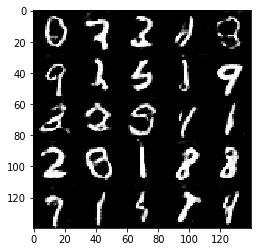

Epoch 2/2... Step 2510 Discriminator Loss: 0.7520... Generator Loss: 1.2771
Epoch 2/2... Step 2520 Discriminator Loss: 0.8066... Generator Loss: 1.2502
Epoch 2/2... Step 2530 Discriminator Loss: 0.6962... Generator Loss: 1.9968
Epoch 2/2... Step 2540 Discriminator Loss: 0.9187... Generator Loss: 1.3080
Epoch 2/2... Step 2550 Discriminator Loss: 1.6238... Generator Loss: 0.4394
Epoch 2/2... Step 2560 Discriminator Loss: 0.9622... Generator Loss: 0.9068
Epoch 2/2... Step 2570 Discriminator Loss: 0.9403... Generator Loss: 2.3365
Epoch 2/2... Step 2580 Discriminator Loss: 0.8580... Generator Loss: 1.0735
Epoch 2/2... Step 2590 Discriminator Loss: 1.0425... Generator Loss: 0.9251
Epoch 2/2... Step 2600 Discriminator Loss: 0.7305... Generator Loss: 1.3118


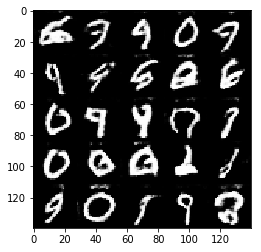

Epoch 2/2... Step 2610 Discriminator Loss: 0.6840... Generator Loss: 1.8943
Epoch 2/2... Step 2620 Discriminator Loss: 1.6038... Generator Loss: 0.4742
Epoch 2/2... Step 2630 Discriminator Loss: 0.6842... Generator Loss: 1.9498
Epoch 2/2... Step 2640 Discriminator Loss: 0.8155... Generator Loss: 1.1537
Epoch 2/2... Step 2650 Discriminator Loss: 0.7283... Generator Loss: 1.3782
Epoch 2/2... Step 2660 Discriminator Loss: 0.7257... Generator Loss: 1.2544
Epoch 2/2... Step 2670 Discriminator Loss: 1.4052... Generator Loss: 0.6469
Epoch 2/2... Step 2680 Discriminator Loss: 0.7471... Generator Loss: 1.8764
Epoch 2/2... Step 2690 Discriminator Loss: 0.9719... Generator Loss: 1.0082
Epoch 2/2... Step 2700 Discriminator Loss: 0.6856... Generator Loss: 1.4412


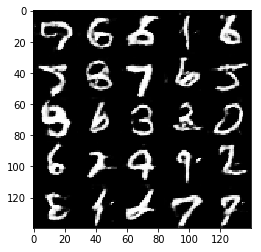

Epoch 2/2... Step 2710 Discriminator Loss: 0.8957... Generator Loss: 1.0011
Epoch 2/2... Step 2720 Discriminator Loss: 0.7287... Generator Loss: 1.5051
Epoch 2/2... Step 2730 Discriminator Loss: 1.3294... Generator Loss: 0.5876
Epoch 2/2... Step 2740 Discriminator Loss: 1.1439... Generator Loss: 2.0128
Epoch 2/2... Step 2750 Discriminator Loss: 0.6775... Generator Loss: 1.5137
Epoch 2/2... Step 2760 Discriminator Loss: 0.5863... Generator Loss: 2.2147
Epoch 2/2... Step 2770 Discriminator Loss: 0.7304... Generator Loss: 1.6477
Epoch 2/2... Step 2780 Discriminator Loss: 1.7783... Generator Loss: 0.3445
Epoch 2/2... Step 2790 Discriminator Loss: 0.8586... Generator Loss: 1.4385
Epoch 2/2... Step 2800 Discriminator Loss: 0.8690... Generator Loss: 1.1708


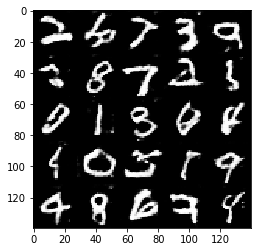

Epoch 2/2... Step 2810 Discriminator Loss: 0.7939... Generator Loss: 1.9655
Epoch 2/2... Step 2820 Discriminator Loss: 1.1753... Generator Loss: 0.7364
Epoch 2/2... Step 2830 Discriminator Loss: 0.5878... Generator Loss: 1.8234
Epoch 2/2... Step 2840 Discriminator Loss: 0.8197... Generator Loss: 2.1083
Epoch 2/2... Step 2850 Discriminator Loss: 1.3839... Generator Loss: 0.5535
Epoch 2/2... Step 2860 Discriminator Loss: 0.7738... Generator Loss: 1.4364
Epoch 2/2... Step 2870 Discriminator Loss: 0.7529... Generator Loss: 1.2726
Epoch 2/2... Step 2880 Discriminator Loss: 1.6976... Generator Loss: 0.4151
Epoch 2/2... Step 2890 Discriminator Loss: 0.7846... Generator Loss: 1.3779
Epoch 2/2... Step 2900 Discriminator Loss: 1.0413... Generator Loss: 0.9126


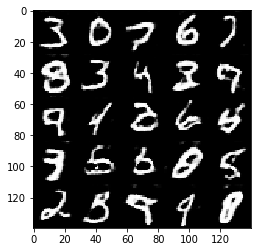

Epoch 2/2... Step 2910 Discriminator Loss: 0.8423... Generator Loss: 1.0609
Epoch 2/2... Step 2920 Discriminator Loss: 0.6037... Generator Loss: 1.8479
Epoch 2/2... Step 2930 Discriminator Loss: 0.7587... Generator Loss: 1.2971
Epoch 2/2... Step 2940 Discriminator Loss: 1.1241... Generator Loss: 0.7217
Epoch 2/2... Step 2950 Discriminator Loss: 0.8650... Generator Loss: 1.1236
Epoch 2/2... Step 2960 Discriminator Loss: 0.7857... Generator Loss: 1.2214
Epoch 2/2... Step 2970 Discriminator Loss: 0.6515... Generator Loss: 1.5451
Epoch 2/2... Step 2980 Discriminator Loss: 1.0074... Generator Loss: 1.0854
Epoch 2/2... Step 2990 Discriminator Loss: 0.6977... Generator Loss: 1.4383
Epoch 2/2... Step 3000 Discriminator Loss: 1.3777... Generator Loss: 0.5837


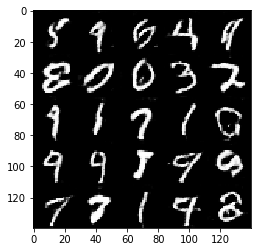

Epoch 2/2... Step 3010 Discriminator Loss: 1.2543... Generator Loss: 0.6091
Epoch 2/2... Step 3020 Discriminator Loss: 1.1241... Generator Loss: 0.8002
Epoch 2/2... Step 3030 Discriminator Loss: 0.7592... Generator Loss: 1.7285
Epoch 2/2... Step 3040 Discriminator Loss: 0.7391... Generator Loss: 2.4369
Epoch 2/2... Step 3050 Discriminator Loss: 0.9356... Generator Loss: 0.9079
Epoch 2/2... Step 3060 Discriminator Loss: 0.6977... Generator Loss: 1.5186
Epoch 2/2... Step 3070 Discriminator Loss: 1.5785... Generator Loss: 0.4942
Epoch 2/2... Step 3080 Discriminator Loss: 0.8455... Generator Loss: 1.0936
Epoch 2/2... Step 3090 Discriminator Loss: 1.0710... Generator Loss: 0.8972
Epoch 2/2... Step 3100 Discriminator Loss: 0.5782... Generator Loss: 1.8823


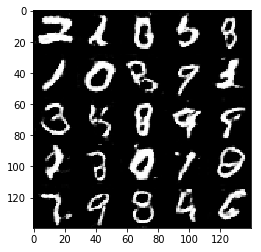

Epoch 2/2... Step 3110 Discriminator Loss: 1.7667... Generator Loss: 0.4028
Epoch 2/2... Step 3120 Discriminator Loss: 1.1341... Generator Loss: 2.8421
Epoch 2/2... Step 3130 Discriminator Loss: 0.7018... Generator Loss: 1.4691
Epoch 2/2... Step 3140 Discriminator Loss: 0.7712... Generator Loss: 1.5077
Epoch 2/2... Step 3150 Discriminator Loss: 0.6656... Generator Loss: 2.0912
Epoch 2/2... Step 3160 Discriminator Loss: 0.5602... Generator Loss: 2.2313
Epoch 2/2... Step 3170 Discriminator Loss: 1.9233... Generator Loss: 0.3195
Epoch 2/2... Step 3180 Discriminator Loss: 0.7035... Generator Loss: 1.8011
Epoch 2/2... Step 3190 Discriminator Loss: 0.9604... Generator Loss: 0.8887
Epoch 2/2... Step 3200 Discriminator Loss: 0.8321... Generator Loss: 1.1207


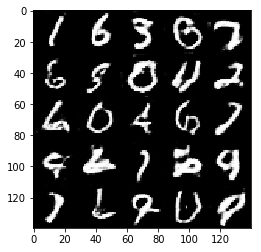

Epoch 2/2... Step 3210 Discriminator Loss: 0.6547... Generator Loss: 1.8545
Epoch 2/2... Step 3220 Discriminator Loss: 0.9193... Generator Loss: 1.0273
Epoch 2/2... Step 3230 Discriminator Loss: 0.6932... Generator Loss: 1.4783
Epoch 2/2... Step 3240 Discriminator Loss: 0.9731... Generator Loss: 0.9374
Epoch 2/2... Step 3250 Discriminator Loss: 0.9347... Generator Loss: 2.8685
Epoch 2/2... Step 3260 Discriminator Loss: 0.8267... Generator Loss: 1.3926
Epoch 2/2... Step 3270 Discriminator Loss: 0.8183... Generator Loss: 2.4043
Epoch 2/2... Step 3280 Discriminator Loss: 0.6443... Generator Loss: 1.9670
Epoch 2/2... Step 3290 Discriminator Loss: 0.7278... Generator Loss: 1.5040
Epoch 2/2... Step 3300 Discriminator Loss: 0.7474... Generator Loss: 1.2750


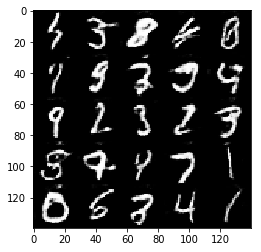

Epoch 2/2... Step 3310 Discriminator Loss: 0.7129... Generator Loss: 1.3239
Epoch 2/2... Step 3320 Discriminator Loss: 1.0050... Generator Loss: 0.8641
Epoch 2/2... Step 3330 Discriminator Loss: 0.8130... Generator Loss: 1.1257
Epoch 2/2... Step 3340 Discriminator Loss: 0.7015... Generator Loss: 2.0148
Epoch 2/2... Step 3350 Discriminator Loss: 0.8616... Generator Loss: 1.2763
Epoch 2/2... Step 3360 Discriminator Loss: 0.7610... Generator Loss: 1.2781
Epoch 2/2... Step 3370 Discriminator Loss: 0.8734... Generator Loss: 1.1313
Epoch 2/2... Step 3380 Discriminator Loss: 0.6911... Generator Loss: 1.6392
Epoch 2/2... Step 3390 Discriminator Loss: 0.7509... Generator Loss: 3.7775
Epoch 2/2... Step 3400 Discriminator Loss: 0.9333... Generator Loss: 1.0364


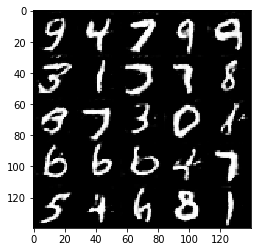

Epoch 2/2... Step 3410 Discriminator Loss: 0.7255... Generator Loss: 1.3599
Epoch 2/2... Step 3420 Discriminator Loss: 1.1208... Generator Loss: 0.8223
Epoch 2/2... Step 3430 Discriminator Loss: 1.0782... Generator Loss: 0.7754
Epoch 2/2... Step 3440 Discriminator Loss: 0.6666... Generator Loss: 1.6700
Epoch 2/2... Step 3450 Discriminator Loss: 0.7434... Generator Loss: 1.2686
Epoch 2/2... Step 3460 Discriminator Loss: 0.6792... Generator Loss: 1.5575
Epoch 2/2... Step 3470 Discriminator Loss: 0.9297... Generator Loss: 0.9573
Epoch 2/2... Step 3480 Discriminator Loss: 0.9482... Generator Loss: 2.2477
Epoch 2/2... Step 3490 Discriminator Loss: 1.3286... Generator Loss: 0.6749
Epoch 2/2... Step 3500 Discriminator Loss: 1.1391... Generator Loss: 0.7990


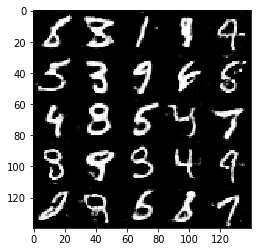

Epoch 2/2... Step 3510 Discriminator Loss: 0.9047... Generator Loss: 1.0816
Epoch 2/2... Step 3520 Discriminator Loss: 0.6744... Generator Loss: 1.7017
Epoch 2/2... Step 3530 Discriminator Loss: 0.5986... Generator Loss: 1.6415
Epoch 2/2... Step 3540 Discriminator Loss: 0.6866... Generator Loss: 1.6287
Epoch 2/2... Step 3550 Discriminator Loss: 0.8612... Generator Loss: 0.9940
Epoch 2/2... Step 3560 Discriminator Loss: 1.6978... Generator Loss: 0.4420
Epoch 2/2... Step 3570 Discriminator Loss: 0.9064... Generator Loss: 0.9685
Epoch 2/2... Step 3580 Discriminator Loss: 0.6233... Generator Loss: 1.4541
Epoch 2/2... Step 3590 Discriminator Loss: 0.8643... Generator Loss: 1.2215
Epoch 2/2... Step 3600 Discriminator Loss: 0.6683... Generator Loss: 1.5040


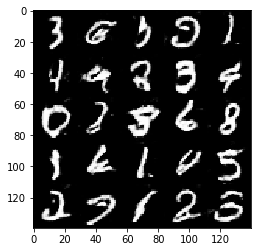

Epoch 2/2... Step 3610 Discriminator Loss: 1.3422... Generator Loss: 0.6338
Epoch 2/2... Step 3620 Discriminator Loss: 0.6552... Generator Loss: 1.5668
Epoch 2/2... Step 3630 Discriminator Loss: 0.6882... Generator Loss: 1.5526
Epoch 2/2... Step 3640 Discriminator Loss: 1.0257... Generator Loss: 0.9153
Epoch 2/2... Step 3650 Discriminator Loss: 2.5808... Generator Loss: 0.2512
Epoch 2/2... Step 3660 Discriminator Loss: 0.9060... Generator Loss: 0.9994
Epoch 2/2... Step 3670 Discriminator Loss: 1.5562... Generator Loss: 0.4493
Epoch 2/2... Step 3680 Discriminator Loss: 0.7891... Generator Loss: 1.6405
Epoch 2/2... Step 3690 Discriminator Loss: 0.7761... Generator Loss: 1.1575
Epoch 2/2... Step 3700 Discriminator Loss: 0.9048... Generator Loss: 0.9912


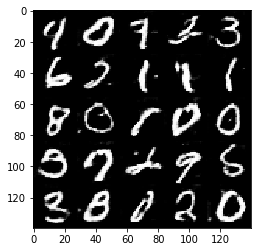

Epoch 2/2... Step 3710 Discriminator Loss: 0.9690... Generator Loss: 1.1370
Epoch 2/2... Step 3720 Discriminator Loss: 0.7230... Generator Loss: 1.2968
Epoch 2/2... Step 3730 Discriminator Loss: 0.5862... Generator Loss: 2.0255
Epoch 2/2... Step 3740 Discriminator Loss: 0.7186... Generator Loss: 1.4044
Epoch 2/2... Step 3750 Discriminator Loss: 0.6156... Generator Loss: 1.8192


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10 Discriminator Loss: 3.0431... Generator Loss: 0.0879
Epoch 1/1... Step 20 Discriminator Loss: 1.1874... Generator Loss: 0.7813
Epoch 1/1... Step 30 Discriminator Loss: 1.4228... Generator Loss: 0.7086
Epoch 1/1... Step 40 Discriminator Loss: 1.8922... Generator Loss: 4.5129
Epoch 1/1... Step 50 Discriminator Loss: 2.5104... Generator Loss: 0.1770
Epoch 1/1... Step 60 Discriminator Loss: 1.4962... Generator Loss: 0.5063
Epoch 1/1... Step 70 Discriminator Loss: 1.6970... Generator Loss: 3.3964
Epoch 1/1... Step 80 Discriminator Loss: 1.8174... Generator Loss: 2.9371
Epoch 1/1... Step 90 Discriminator Loss: 1.3086... Generator Loss: 1.6501
Epoch 1/1... Step 100 Discriminator Loss: 1.6658... Generator Loss: 0.4898


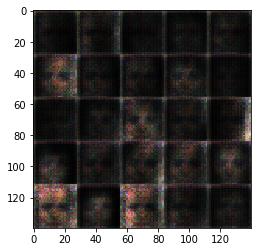

Epoch 1/1... Step 110 Discriminator Loss: 1.3005... Generator Loss: 1.7962
Epoch 1/1... Step 120 Discriminator Loss: 1.3534... Generator Loss: 1.9085
Epoch 1/1... Step 130 Discriminator Loss: 1.3427... Generator Loss: 3.6796
Epoch 1/1... Step 140 Discriminator Loss: 1.9638... Generator Loss: 2.5256
Epoch 1/1... Step 150 Discriminator Loss: 1.3380... Generator Loss: 0.7941
Epoch 1/1... Step 160 Discriminator Loss: 1.1422... Generator Loss: 0.9776
Epoch 1/1... Step 170 Discriminator Loss: 1.3836... Generator Loss: 0.5789
Epoch 1/1... Step 180 Discriminator Loss: 1.1596... Generator Loss: 0.8724
Epoch 1/1... Step 190 Discriminator Loss: 1.5715... Generator Loss: 2.7996
Epoch 1/1... Step 200 Discriminator Loss: 1.2680... Generator Loss: 0.9649


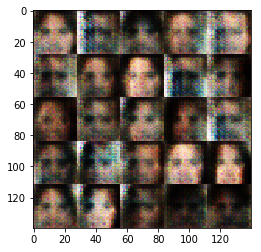

Epoch 1/1... Step 210 Discriminator Loss: 1.3580... Generator Loss: 0.5624
Epoch 1/1... Step 220 Discriminator Loss: 1.0925... Generator Loss: 0.8553
Epoch 1/1... Step 230 Discriminator Loss: 2.0503... Generator Loss: 0.2657
Epoch 1/1... Step 240 Discriminator Loss: 1.5783... Generator Loss: 0.5803
Epoch 1/1... Step 250 Discriminator Loss: 1.4073... Generator Loss: 0.7275
Epoch 1/1... Step 260 Discriminator Loss: 1.0488... Generator Loss: 1.0084
Epoch 1/1... Step 270 Discriminator Loss: 1.5927... Generator Loss: 0.4207
Epoch 1/1... Step 280 Discriminator Loss: 0.9387... Generator Loss: 1.0253
Epoch 1/1... Step 290 Discriminator Loss: 1.0566... Generator Loss: 1.4897
Epoch 1/1... Step 300 Discriminator Loss: 1.0487... Generator Loss: 1.3049


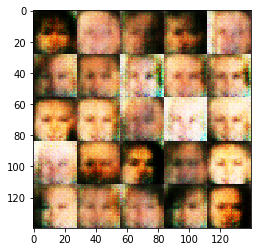

Epoch 1/1... Step 310 Discriminator Loss: 1.3822... Generator Loss: 0.9436
Epoch 1/1... Step 320 Discriminator Loss: 1.2282... Generator Loss: 1.0757
Epoch 1/1... Step 330 Discriminator Loss: 1.2808... Generator Loss: 2.3853
Epoch 1/1... Step 340 Discriminator Loss: 1.0749... Generator Loss: 1.0260
Epoch 1/1... Step 350 Discriminator Loss: 1.6117... Generator Loss: 0.3838
Epoch 1/1... Step 360 Discriminator Loss: 1.3302... Generator Loss: 0.5847
Epoch 1/1... Step 370 Discriminator Loss: 1.0561... Generator Loss: 1.2671
Epoch 1/1... Step 380 Discriminator Loss: 1.2567... Generator Loss: 0.6889
Epoch 1/1... Step 390 Discriminator Loss: 1.3638... Generator Loss: 0.9130
Epoch 1/1... Step 400 Discriminator Loss: 0.8516... Generator Loss: 1.4965


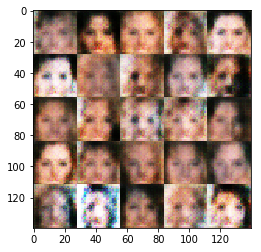

Epoch 1/1... Step 410 Discriminator Loss: 1.1964... Generator Loss: 1.0965
Epoch 1/1... Step 420 Discriminator Loss: 1.3985... Generator Loss: 0.5772
Epoch 1/1... Step 430 Discriminator Loss: 1.2174... Generator Loss: 0.8051
Epoch 1/1... Step 440 Discriminator Loss: 0.9198... Generator Loss: 1.2162
Epoch 1/1... Step 450 Discriminator Loss: 1.0772... Generator Loss: 1.0386
Epoch 1/1... Step 460 Discriminator Loss: 1.2474... Generator Loss: 0.6335
Epoch 1/1... Step 470 Discriminator Loss: 1.1578... Generator Loss: 1.1508
Epoch 1/1... Step 480 Discriminator Loss: 1.0028... Generator Loss: 1.3741
Epoch 1/1... Step 490 Discriminator Loss: 1.6752... Generator Loss: 0.4152
Epoch 1/1... Step 500 Discriminator Loss: 1.1345... Generator Loss: 0.9461


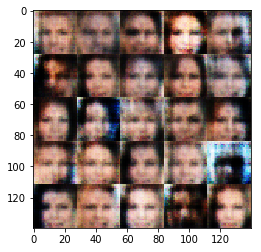

Epoch 1/1... Step 510 Discriminator Loss: 1.0962... Generator Loss: 0.9221
Epoch 1/1... Step 520 Discriminator Loss: 1.2693... Generator Loss: 0.6502
Epoch 1/1... Step 530 Discriminator Loss: 1.1888... Generator Loss: 1.9629
Epoch 1/1... Step 540 Discriminator Loss: 1.5287... Generator Loss: 0.4501
Epoch 1/1... Step 550 Discriminator Loss: 1.2044... Generator Loss: 0.7462
Epoch 1/1... Step 560 Discriminator Loss: 1.1801... Generator Loss: 1.2613
Epoch 1/1... Step 570 Discriminator Loss: 1.2147... Generator Loss: 0.7444
Epoch 1/1... Step 580 Discriminator Loss: 1.3962... Generator Loss: 2.0045
Epoch 1/1... Step 590 Discriminator Loss: 1.0122... Generator Loss: 1.3031
Epoch 1/1... Step 600 Discriminator Loss: 1.3460... Generator Loss: 0.9993


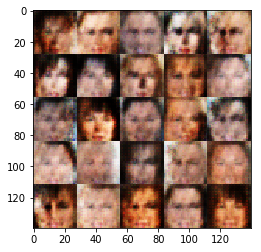

Epoch 1/1... Step 610 Discriminator Loss: 1.5506... Generator Loss: 0.4433
Epoch 1/1... Step 620 Discriminator Loss: 1.4147... Generator Loss: 0.5006
Epoch 1/1... Step 630 Discriminator Loss: 1.4320... Generator Loss: 0.5091
Epoch 1/1... Step 640 Discriminator Loss: 1.3191... Generator Loss: 0.7227
Epoch 1/1... Step 650 Discriminator Loss: 1.1664... Generator Loss: 1.3687
Epoch 1/1... Step 660 Discriminator Loss: 0.9869... Generator Loss: 1.1095
Epoch 1/1... Step 670 Discriminator Loss: 1.1879... Generator Loss: 0.7262
Epoch 1/1... Step 680 Discriminator Loss: 1.1613... Generator Loss: 0.9833
Epoch 1/1... Step 690 Discriminator Loss: 1.0788... Generator Loss: 1.0512
Epoch 1/1... Step 700 Discriminator Loss: 1.7287... Generator Loss: 0.3272


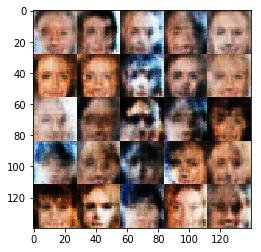

Epoch 1/1... Step 710 Discriminator Loss: 1.0908... Generator Loss: 1.5083
Epoch 1/1... Step 720 Discriminator Loss: 0.9945... Generator Loss: 1.2774
Epoch 1/1... Step 730 Discriminator Loss: 1.4228... Generator Loss: 0.6240
Epoch 1/1... Step 740 Discriminator Loss: 1.0251... Generator Loss: 0.7783
Epoch 1/1... Step 750 Discriminator Loss: 1.3488... Generator Loss: 0.7970
Epoch 1/1... Step 760 Discriminator Loss: 1.1728... Generator Loss: 0.8636
Epoch 1/1... Step 770 Discriminator Loss: 1.1838... Generator Loss: 1.7843
Epoch 1/1... Step 780 Discriminator Loss: 1.0779... Generator Loss: 1.5634
Epoch 1/1... Step 790 Discriminator Loss: 1.1525... Generator Loss: 1.0078
Epoch 1/1... Step 800 Discriminator Loss: 1.0505... Generator Loss: 1.0895


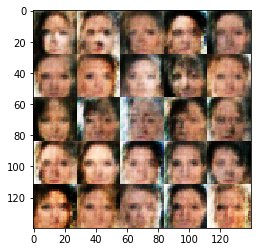

Epoch 1/1... Step 810 Discriminator Loss: 1.1727... Generator Loss: 0.7127
Epoch 1/1... Step 820 Discriminator Loss: 2.8484... Generator Loss: 3.3829
Epoch 1/1... Step 830 Discriminator Loss: 1.2833... Generator Loss: 1.4923
Epoch 1/1... Step 840 Discriminator Loss: 1.0217... Generator Loss: 1.4125
Epoch 1/1... Step 850 Discriminator Loss: 1.7170... Generator Loss: 0.3240
Epoch 1/1... Step 860 Discriminator Loss: 0.9763... Generator Loss: 1.3659
Epoch 1/1... Step 870 Discriminator Loss: 1.1421... Generator Loss: 0.9227
Epoch 1/1... Step 880 Discriminator Loss: 1.2648... Generator Loss: 0.7613
Epoch 1/1... Step 890 Discriminator Loss: 1.0817... Generator Loss: 1.2967
Epoch 1/1... Step 900 Discriminator Loss: 1.2989... Generator Loss: 1.1678


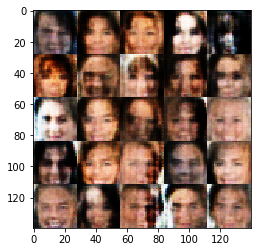

Epoch 1/1... Step 910 Discriminator Loss: 1.2111... Generator Loss: 0.6830
Epoch 1/1... Step 920 Discriminator Loss: 1.2838... Generator Loss: 2.0807
Epoch 1/1... Step 930 Discriminator Loss: 0.9878... Generator Loss: 1.6208
Epoch 1/1... Step 940 Discriminator Loss: 1.8392... Generator Loss: 2.6641
Epoch 1/1... Step 950 Discriminator Loss: 1.0989... Generator Loss: 0.8297
Epoch 1/1... Step 960 Discriminator Loss: 1.1092... Generator Loss: 0.8154
Epoch 1/1... Step 970 Discriminator Loss: 1.1109... Generator Loss: 0.8321
Epoch 1/1... Step 980 Discriminator Loss: 0.8335... Generator Loss: 2.1478
Epoch 1/1... Step 990 Discriminator Loss: 0.9736... Generator Loss: 1.2458
Epoch 1/1... Step 1000 Discriminator Loss: 0.7887... Generator Loss: 1.2996


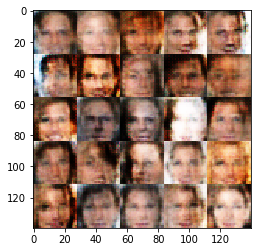

Epoch 1/1... Step 1010 Discriminator Loss: 1.2188... Generator Loss: 0.7885
Epoch 1/1... Step 1020 Discriminator Loss: 1.1361... Generator Loss: 0.7747
Epoch 1/1... Step 1030 Discriminator Loss: 1.5701... Generator Loss: 2.5509
Epoch 1/1... Step 1040 Discriminator Loss: 1.2200... Generator Loss: 1.4360
Epoch 1/1... Step 1050 Discriminator Loss: 0.8839... Generator Loss: 1.1857
Epoch 1/1... Step 1060 Discriminator Loss: 1.0153... Generator Loss: 1.3946
Epoch 1/1... Step 1070 Discriminator Loss: 1.1491... Generator Loss: 0.7709
Epoch 1/1... Step 1080 Discriminator Loss: 1.0493... Generator Loss: 1.1830
Epoch 1/1... Step 1090 Discriminator Loss: 1.3593... Generator Loss: 0.4942
Epoch 1/1... Step 1100 Discriminator Loss: 1.0833... Generator Loss: 1.0174


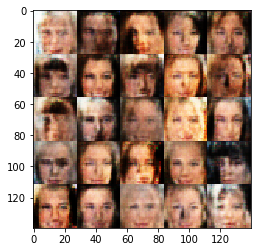

Epoch 1/1... Step 1110 Discriminator Loss: 0.9303... Generator Loss: 1.0793
Epoch 1/1... Step 1120 Discriminator Loss: 1.0061... Generator Loss: 0.9146
Epoch 1/1... Step 1130 Discriminator Loss: 1.4046... Generator Loss: 0.7348
Epoch 1/1... Step 1140 Discriminator Loss: 1.2152... Generator Loss: 0.7249
Epoch 1/1... Step 1150 Discriminator Loss: 1.1661... Generator Loss: 0.7975
Epoch 1/1... Step 1160 Discriminator Loss: 1.0268... Generator Loss: 1.5314
Epoch 1/1... Step 1170 Discriminator Loss: 1.0694... Generator Loss: 1.1295
Epoch 1/1... Step 1180 Discriminator Loss: 1.0047... Generator Loss: 1.8599
Epoch 1/1... Step 1190 Discriminator Loss: 1.0433... Generator Loss: 1.3643
Epoch 1/1... Step 1200 Discriminator Loss: 1.6054... Generator Loss: 2.3251


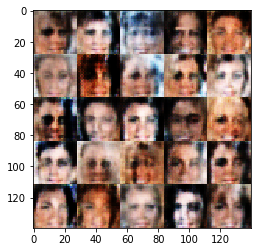

Epoch 1/1... Step 1210 Discriminator Loss: 1.3597... Generator Loss: 2.1716
Epoch 1/1... Step 1220 Discriminator Loss: 1.0794... Generator Loss: 1.2267
Epoch 1/1... Step 1230 Discriminator Loss: 1.3141... Generator Loss: 0.7828
Epoch 1/1... Step 1240 Discriminator Loss: 1.0398... Generator Loss: 0.7984
Epoch 1/1... Step 1250 Discriminator Loss: 1.4118... Generator Loss: 0.5063
Epoch 1/1... Step 1260 Discriminator Loss: 1.2178... Generator Loss: 1.5683
Epoch 1/1... Step 1270 Discriminator Loss: 1.0653... Generator Loss: 1.0080
Epoch 1/1... Step 1280 Discriminator Loss: 0.8075... Generator Loss: 1.4602
Epoch 1/1... Step 1290 Discriminator Loss: 1.1957... Generator Loss: 0.6980
Epoch 1/1... Step 1300 Discriminator Loss: 1.2854... Generator Loss: 0.5666


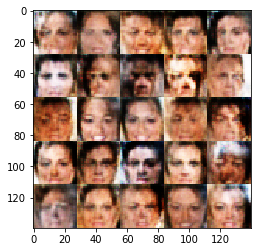

Epoch 1/1... Step 1310 Discriminator Loss: 1.1966... Generator Loss: 0.7278
Epoch 1/1... Step 1320 Discriminator Loss: 1.4896... Generator Loss: 0.4230
Epoch 1/1... Step 1330 Discriminator Loss: 1.2251... Generator Loss: 1.3484
Epoch 1/1... Step 1340 Discriminator Loss: 1.2963... Generator Loss: 1.4182
Epoch 1/1... Step 1350 Discriminator Loss: 1.0454... Generator Loss: 1.0989
Epoch 1/1... Step 1360 Discriminator Loss: 1.3416... Generator Loss: 1.5542
Epoch 1/1... Step 1370 Discriminator Loss: 1.2431... Generator Loss: 1.5960
Epoch 1/1... Step 1380 Discriminator Loss: 1.0266... Generator Loss: 1.6080
Epoch 1/1... Step 1390 Discriminator Loss: 1.0518... Generator Loss: 1.1975
Epoch 1/1... Step 1400 Discriminator Loss: 1.2160... Generator Loss: 1.2983


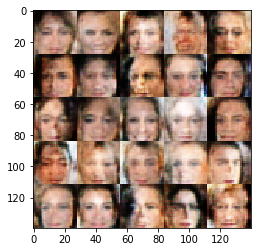

Epoch 1/1... Step 1410 Discriminator Loss: 0.8725... Generator Loss: 1.7238
Epoch 1/1... Step 1420 Discriminator Loss: 1.1510... Generator Loss: 0.8724
Epoch 1/1... Step 1430 Discriminator Loss: 1.2842... Generator Loss: 1.0256
Epoch 1/1... Step 1440 Discriminator Loss: 1.1953... Generator Loss: 1.0158
Epoch 1/1... Step 1450 Discriminator Loss: 0.9332... Generator Loss: 0.9953
Epoch 1/1... Step 1460 Discriminator Loss: 0.9893... Generator Loss: 1.0808
Epoch 1/1... Step 1470 Discriminator Loss: 0.9832... Generator Loss: 1.3422
Epoch 1/1... Step 1480 Discriminator Loss: 1.1982... Generator Loss: 0.7604
Epoch 1/1... Step 1490 Discriminator Loss: 1.1653... Generator Loss: 0.7802
Epoch 1/1... Step 1500 Discriminator Loss: 0.9636... Generator Loss: 2.1737


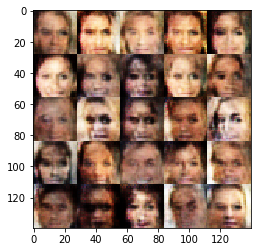

Epoch 1/1... Step 1510 Discriminator Loss: 1.1281... Generator Loss: 1.3073
Epoch 1/1... Step 1520 Discriminator Loss: 1.2939... Generator Loss: 2.0136
Epoch 1/1... Step 1530 Discriminator Loss: 1.0981... Generator Loss: 1.2063
Epoch 1/1... Step 1540 Discriminator Loss: 1.1461... Generator Loss: 0.7251
Epoch 1/1... Step 1550 Discriminator Loss: 1.1198... Generator Loss: 1.2694
Epoch 1/1... Step 1560 Discriminator Loss: 1.3171... Generator Loss: 0.5317
Epoch 1/1... Step 1570 Discriminator Loss: 1.4765... Generator Loss: 0.4289
Epoch 1/1... Step 1580 Discriminator Loss: 1.0505... Generator Loss: 0.8652
Epoch 1/1... Step 1590 Discriminator Loss: 2.1613... Generator Loss: 0.2133
Epoch 1/1... Step 1600 Discriminator Loss: 1.3527... Generator Loss: 0.5236


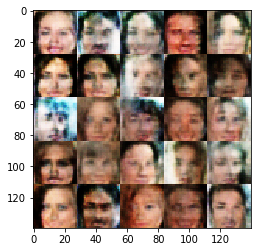

Epoch 1/1... Step 1610 Discriminator Loss: 1.2334... Generator Loss: 0.6347
Epoch 1/1... Step 1620 Discriminator Loss: 0.9361... Generator Loss: 0.9637
Epoch 1/1... Step 1630 Discriminator Loss: 1.1371... Generator Loss: 0.7718
Epoch 1/1... Step 1640 Discriminator Loss: 1.2829... Generator Loss: 0.6172
Epoch 1/1... Step 1650 Discriminator Loss: 1.3840... Generator Loss: 0.4785
Epoch 1/1... Step 1660 Discriminator Loss: 1.1447... Generator Loss: 1.1910
Epoch 1/1... Step 1670 Discriminator Loss: 1.1734... Generator Loss: 0.7416
Epoch 1/1... Step 1680 Discriminator Loss: 1.2873... Generator Loss: 1.9687
Epoch 1/1... Step 1690 Discriminator Loss: 1.0390... Generator Loss: 0.8555
Epoch 1/1... Step 1700 Discriminator Loss: 1.1803... Generator Loss: 0.6980


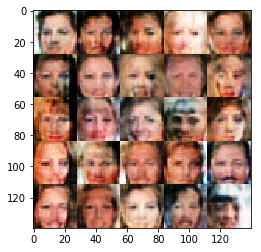

Epoch 1/1... Step 1710 Discriminator Loss: 1.0122... Generator Loss: 0.9098
Epoch 1/1... Step 1720 Discriminator Loss: 1.8929... Generator Loss: 1.9287
Epoch 1/1... Step 1730 Discriminator Loss: 1.3589... Generator Loss: 1.7610
Epoch 1/1... Step 1740 Discriminator Loss: 1.0817... Generator Loss: 1.8101
Epoch 1/1... Step 1750 Discriminator Loss: 1.2526... Generator Loss: 1.0296
Epoch 1/1... Step 1760 Discriminator Loss: 0.7506... Generator Loss: 1.8302
Epoch 1/1... Step 1770 Discriminator Loss: 0.9330... Generator Loss: 2.1008
Epoch 1/1... Step 1780 Discriminator Loss: 1.1260... Generator Loss: 0.7525
Epoch 1/1... Step 1790 Discriminator Loss: 1.4163... Generator Loss: 0.5447
Epoch 1/1... Step 1800 Discriminator Loss: 1.2774... Generator Loss: 0.6112


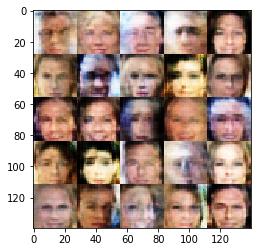

Epoch 1/1... Step 1810 Discriminator Loss: 1.1050... Generator Loss: 0.8091
Epoch 1/1... Step 1820 Discriminator Loss: 1.2780... Generator Loss: 0.6262
Epoch 1/1... Step 1830 Discriminator Loss: 1.0083... Generator Loss: 0.8483
Epoch 1/1... Step 1840 Discriminator Loss: 1.4162... Generator Loss: 2.3985
Epoch 1/1... Step 1850 Discriminator Loss: 1.0004... Generator Loss: 1.5673
Epoch 1/1... Step 1860 Discriminator Loss: 1.0550... Generator Loss: 1.5461
Epoch 1/1... Step 1870 Discriminator Loss: 0.8753... Generator Loss: 1.3254
Epoch 1/1... Step 1880 Discriminator Loss: 0.8806... Generator Loss: 1.5101
Epoch 1/1... Step 1890 Discriminator Loss: 1.3168... Generator Loss: 0.6805
Epoch 1/1... Step 1900 Discriminator Loss: 1.0063... Generator Loss: 0.9498


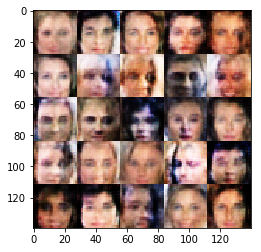

Epoch 1/1... Step 1910 Discriminator Loss: 0.9225... Generator Loss: 1.4441
Epoch 1/1... Step 1920 Discriminator Loss: 1.3058... Generator Loss: 0.6241
Epoch 1/1... Step 1930 Discriminator Loss: 1.0777... Generator Loss: 0.7636
Epoch 1/1... Step 1940 Discriminator Loss: 0.9536... Generator Loss: 1.1375
Epoch 1/1... Step 1950 Discriminator Loss: 1.1547... Generator Loss: 0.9169
Epoch 1/1... Step 1960 Discriminator Loss: 1.0164... Generator Loss: 1.5083
Epoch 1/1... Step 1970 Discriminator Loss: 0.7940... Generator Loss: 1.8902
Epoch 1/1... Step 1980 Discriminator Loss: 1.1015... Generator Loss: 0.7586
Epoch 1/1... Step 1990 Discriminator Loss: 1.0758... Generator Loss: 0.8802
Epoch 1/1... Step 2000 Discriminator Loss: 0.9938... Generator Loss: 0.8221


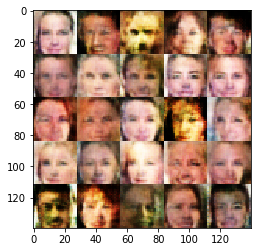

Epoch 1/1... Step 2010 Discriminator Loss: 1.1095... Generator Loss: 0.8726
Epoch 1/1... Step 2020 Discriminator Loss: 1.1899... Generator Loss: 0.6980
Epoch 1/1... Step 2030 Discriminator Loss: 1.6066... Generator Loss: 1.7882
Epoch 1/1... Step 2040 Discriminator Loss: 1.0666... Generator Loss: 0.9719
Epoch 1/1... Step 2050 Discriminator Loss: 1.6587... Generator Loss: 0.3601
Epoch 1/1... Step 2060 Discriminator Loss: 1.3893... Generator Loss: 0.4787
Epoch 1/1... Step 2070 Discriminator Loss: 0.8994... Generator Loss: 1.0442
Epoch 1/1... Step 2080 Discriminator Loss: 1.6076... Generator Loss: 0.3872
Epoch 1/1... Step 2090 Discriminator Loss: 1.2529... Generator Loss: 0.7356
Epoch 1/1... Step 2100 Discriminator Loss: 1.2789... Generator Loss: 0.8563


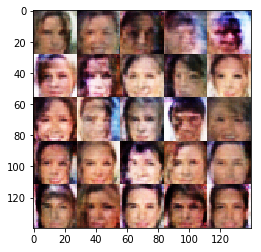

Epoch 1/1... Step 2110 Discriminator Loss: 0.9503... Generator Loss: 1.1836
Epoch 1/1... Step 2120 Discriminator Loss: 1.5163... Generator Loss: 0.4032
Epoch 1/1... Step 2130 Discriminator Loss: 1.0159... Generator Loss: 0.9429
Epoch 1/1... Step 2140 Discriminator Loss: 0.9576... Generator Loss: 1.2937
Epoch 1/1... Step 2150 Discriminator Loss: 1.0095... Generator Loss: 0.9756
Epoch 1/1... Step 2160 Discriminator Loss: 1.0893... Generator Loss: 0.7586
Epoch 1/1... Step 2170 Discriminator Loss: 1.0798... Generator Loss: 0.9398
Epoch 1/1... Step 2180 Discriminator Loss: 1.1484... Generator Loss: 0.7476
Epoch 1/1... Step 2190 Discriminator Loss: 0.9315... Generator Loss: 1.8377
Epoch 1/1... Step 2200 Discriminator Loss: 1.3905... Generator Loss: 0.4892


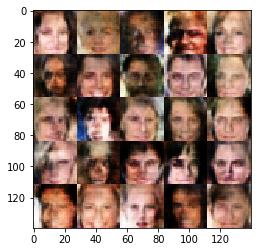

Epoch 1/1... Step 2210 Discriminator Loss: 1.2383... Generator Loss: 0.6667
Epoch 1/1... Step 2220 Discriminator Loss: 1.2453... Generator Loss: 0.6038
Epoch 1/1... Step 2230 Discriminator Loss: 1.0723... Generator Loss: 1.0901
Epoch 1/1... Step 2240 Discriminator Loss: 1.0157... Generator Loss: 1.0210
Epoch 1/1... Step 2250 Discriminator Loss: 1.5113... Generator Loss: 0.4234
Epoch 1/1... Step 2260 Discriminator Loss: 0.7872... Generator Loss: 1.3209
Epoch 1/1... Step 2270 Discriminator Loss: 1.0599... Generator Loss: 0.9308
Epoch 1/1... Step 2280 Discriminator Loss: 1.1454... Generator Loss: 0.7948
Epoch 1/1... Step 2290 Discriminator Loss: 0.8088... Generator Loss: 1.4255
Epoch 1/1... Step 2300 Discriminator Loss: 1.3017... Generator Loss: 0.5809


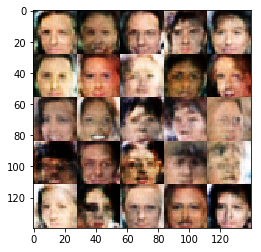

Epoch 1/1... Step 2310 Discriminator Loss: 0.9270... Generator Loss: 1.4815
Epoch 1/1... Step 2320 Discriminator Loss: 1.1142... Generator Loss: 0.9795
Epoch 1/1... Step 2330 Discriminator Loss: 0.8676... Generator Loss: 1.2917
Epoch 1/1... Step 2340 Discriminator Loss: 1.3467... Generator Loss: 0.6197
Epoch 1/1... Step 2350 Discriminator Loss: 1.0757... Generator Loss: 0.7881
Epoch 1/1... Step 2360 Discriminator Loss: 1.2863... Generator Loss: 0.5722
Epoch 1/1... Step 2370 Discriminator Loss: 1.5040... Generator Loss: 1.8156
Epoch 1/1... Step 2380 Discriminator Loss: 1.1635... Generator Loss: 1.2979
Epoch 1/1... Step 2390 Discriminator Loss: 0.8404... Generator Loss: 1.3727
Epoch 1/1... Step 2400 Discriminator Loss: 1.3252... Generator Loss: 0.9596


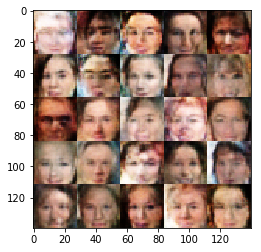

Epoch 1/1... Step 2410 Discriminator Loss: 0.9430... Generator Loss: 1.0847
Epoch 1/1... Step 2420 Discriminator Loss: 1.0027... Generator Loss: 1.0029
Epoch 1/1... Step 2430 Discriminator Loss: 1.3159... Generator Loss: 0.5780
Epoch 1/1... Step 2440 Discriminator Loss: 1.3006... Generator Loss: 0.8593
Epoch 1/1... Step 2450 Discriminator Loss: 0.9651... Generator Loss: 1.1685
Epoch 1/1... Step 2460 Discriminator Loss: 1.0506... Generator Loss: 1.1678
Epoch 1/1... Step 2470 Discriminator Loss: 1.1720... Generator Loss: 1.6470
Epoch 1/1... Step 2480 Discriminator Loss: 1.1737... Generator Loss: 1.2138
Epoch 1/1... Step 2490 Discriminator Loss: 0.9430... Generator Loss: 1.2385
Epoch 1/1... Step 2500 Discriminator Loss: 0.9011... Generator Loss: 1.5549


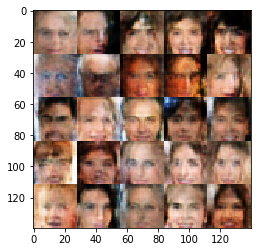

Epoch 1/1... Step 2510 Discriminator Loss: 1.2711... Generator Loss: 1.7749
Epoch 1/1... Step 2520 Discriminator Loss: 1.0963... Generator Loss: 1.3886
Epoch 1/1... Step 2530 Discriminator Loss: 1.1333... Generator Loss: 0.6901
Epoch 1/1... Step 2540 Discriminator Loss: 1.6367... Generator Loss: 0.3533
Epoch 1/1... Step 2550 Discriminator Loss: 1.1038... Generator Loss: 0.8627
Epoch 1/1... Step 2560 Discriminator Loss: 1.5020... Generator Loss: 0.4343
Epoch 1/1... Step 2570 Discriminator Loss: 0.9467... Generator Loss: 1.2055
Epoch 1/1... Step 2580 Discriminator Loss: 0.8549... Generator Loss: 1.2454
Epoch 1/1... Step 2590 Discriminator Loss: 1.1857... Generator Loss: 1.0611
Epoch 1/1... Step 2600 Discriminator Loss: 1.2164... Generator Loss: 0.7099


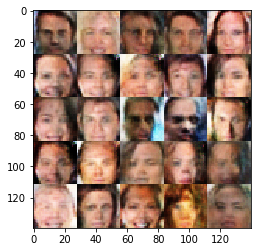

Epoch 1/1... Step 2610 Discriminator Loss: 0.9430... Generator Loss: 0.9538
Epoch 1/1... Step 2620 Discriminator Loss: 1.2436... Generator Loss: 0.5975
Epoch 1/1... Step 2630 Discriminator Loss: 1.4728... Generator Loss: 0.4616
Epoch 1/1... Step 2640 Discriminator Loss: 0.9282... Generator Loss: 1.0940
Epoch 1/1... Step 2650 Discriminator Loss: 1.0417... Generator Loss: 0.8976
Epoch 1/1... Step 2660 Discriminator Loss: 1.3999... Generator Loss: 0.4650
Epoch 1/1... Step 2670 Discriminator Loss: 1.1532... Generator Loss: 2.0546
Epoch 1/1... Step 2680 Discriminator Loss: 1.0630... Generator Loss: 0.9565
Epoch 1/1... Step 2690 Discriminator Loss: 0.9795... Generator Loss: 1.0846
Epoch 1/1... Step 2700 Discriminator Loss: 1.0328... Generator Loss: 0.8721


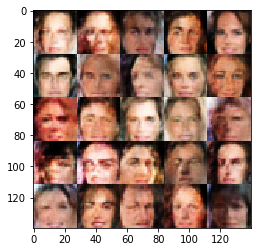

Epoch 1/1... Step 2710 Discriminator Loss: 0.8389... Generator Loss: 1.4093
Epoch 1/1... Step 2720 Discriminator Loss: 0.9671... Generator Loss: 1.0210
Epoch 1/1... Step 2730 Discriminator Loss: 1.0439... Generator Loss: 0.7777
Epoch 1/1... Step 2740 Discriminator Loss: 1.1213... Generator Loss: 0.8082
Epoch 1/1... Step 2750 Discriminator Loss: 1.2104... Generator Loss: 0.6989
Epoch 1/1... Step 2760 Discriminator Loss: 0.8396... Generator Loss: 1.3306
Epoch 1/1... Step 2770 Discriminator Loss: 1.2271... Generator Loss: 0.6953
Epoch 1/1... Step 2780 Discriminator Loss: 1.2432... Generator Loss: 0.8483
Epoch 1/1... Step 2790 Discriminator Loss: 0.9108... Generator Loss: 1.2735
Epoch 1/1... Step 2800 Discriminator Loss: 1.1007... Generator Loss: 0.7131


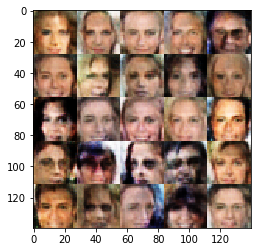

Epoch 1/1... Step 2810 Discriminator Loss: 1.3008... Generator Loss: 0.5458
Epoch 1/1... Step 2820 Discriminator Loss: 1.0536... Generator Loss: 0.8815
Epoch 1/1... Step 2830 Discriminator Loss: 1.1692... Generator Loss: 0.7142
Epoch 1/1... Step 2840 Discriminator Loss: 0.9535... Generator Loss: 0.8997
Epoch 1/1... Step 2850 Discriminator Loss: 1.5278... Generator Loss: 0.3929
Epoch 1/1... Step 2860 Discriminator Loss: 1.0469... Generator Loss: 0.9322
Epoch 1/1... Step 2870 Discriminator Loss: 0.7835... Generator Loss: 1.3704
Epoch 1/1... Step 2880 Discriminator Loss: 1.1601... Generator Loss: 0.8937
Epoch 1/1... Step 2890 Discriminator Loss: 1.3312... Generator Loss: 0.5197
Epoch 1/1... Step 2900 Discriminator Loss: 0.9676... Generator Loss: 1.9615


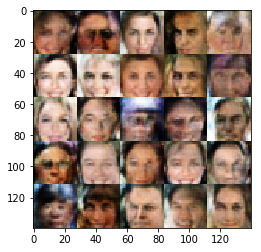

Epoch 1/1... Step 2910 Discriminator Loss: 1.0298... Generator Loss: 1.1150
Epoch 1/1... Step 2920 Discriminator Loss: 1.0279... Generator Loss: 0.8038
Epoch 1/1... Step 2930 Discriminator Loss: 1.0034... Generator Loss: 0.8869
Epoch 1/1... Step 2940 Discriminator Loss: 1.0170... Generator Loss: 0.9378
Epoch 1/1... Step 2950 Discriminator Loss: 0.8312... Generator Loss: 1.0522
Epoch 1/1... Step 2960 Discriminator Loss: 0.9859... Generator Loss: 1.2711
Epoch 1/1... Step 2970 Discriminator Loss: 0.8967... Generator Loss: 1.5066
Epoch 1/1... Step 2980 Discriminator Loss: 1.2216... Generator Loss: 0.7360
Epoch 1/1... Step 2990 Discriminator Loss: 0.9335... Generator Loss: 1.7542
Epoch 1/1... Step 3000 Discriminator Loss: 0.7524... Generator Loss: 1.3038


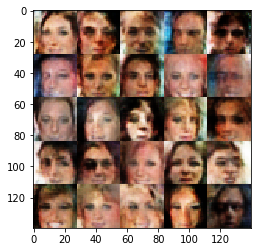

Epoch 1/1... Step 3010 Discriminator Loss: 1.9227... Generator Loss: 0.2734
Epoch 1/1... Step 3020 Discriminator Loss: 1.0555... Generator Loss: 0.9978
Epoch 1/1... Step 3030 Discriminator Loss: 1.0979... Generator Loss: 1.1074
Epoch 1/1... Step 3040 Discriminator Loss: 1.2045... Generator Loss: 0.6520
Epoch 1/1... Step 3050 Discriminator Loss: 1.3797... Generator Loss: 1.7493
Epoch 1/1... Step 3060 Discriminator Loss: 0.9310... Generator Loss: 1.1476
Epoch 1/1... Step 3070 Discriminator Loss: 1.3496... Generator Loss: 0.5379
Epoch 1/1... Step 3080 Discriminator Loss: 1.3844... Generator Loss: 0.4934
Epoch 1/1... Step 3090 Discriminator Loss: 1.5330... Generator Loss: 0.4311
Epoch 1/1... Step 3100 Discriminator Loss: 1.0369... Generator Loss: 1.2849


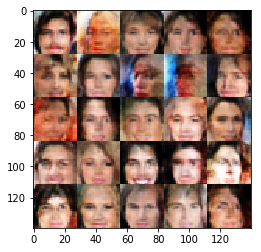

Epoch 1/1... Step 3110 Discriminator Loss: 1.3237... Generator Loss: 1.8358
Epoch 1/1... Step 3120 Discriminator Loss: 1.1663... Generator Loss: 1.4503
Epoch 1/1... Step 3130 Discriminator Loss: 1.3707... Generator Loss: 0.5117
Epoch 1/1... Step 3140 Discriminator Loss: 1.2050... Generator Loss: 0.6860
Epoch 1/1... Step 3150 Discriminator Loss: 1.0138... Generator Loss: 1.9319
Epoch 1/1... Step 3160 Discriminator Loss: 0.9058... Generator Loss: 1.0498
Epoch 1/1... Step 3170 Discriminator Loss: 1.0977... Generator Loss: 0.7495
Epoch 1/1... Step 3180 Discriminator Loss: 1.3673... Generator Loss: 0.5454
Epoch 1/1... Step 3190 Discriminator Loss: 1.2211... Generator Loss: 1.9997
Epoch 1/1... Step 3200 Discriminator Loss: 1.2395... Generator Loss: 0.8736


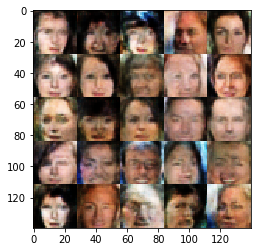

Epoch 1/1... Step 3210 Discriminator Loss: 1.1226... Generator Loss: 0.7721
Epoch 1/1... Step 3220 Discriminator Loss: 1.3209... Generator Loss: 1.5250
Epoch 1/1... Step 3230 Discriminator Loss: 0.9261... Generator Loss: 1.2311
Epoch 1/1... Step 3240 Discriminator Loss: 0.9106... Generator Loss: 1.8775
Epoch 1/1... Step 3250 Discriminator Loss: 1.2543... Generator Loss: 0.7338
Epoch 1/1... Step 3260 Discriminator Loss: 0.9780... Generator Loss: 1.3180
Epoch 1/1... Step 3270 Discriminator Loss: 1.2487... Generator Loss: 1.4362
Epoch 1/1... Step 3280 Discriminator Loss: 0.9620... Generator Loss: 1.0816
Epoch 1/1... Step 3290 Discriminator Loss: 1.2201... Generator Loss: 0.6007
Epoch 1/1... Step 3300 Discriminator Loss: 1.2149... Generator Loss: 0.6142


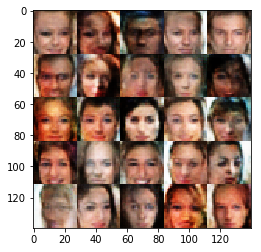

Epoch 1/1... Step 3310 Discriminator Loss: 1.0927... Generator Loss: 0.8048
Epoch 1/1... Step 3320 Discriminator Loss: 0.8977... Generator Loss: 1.4818
Epoch 1/1... Step 3330 Discriminator Loss: 1.2309... Generator Loss: 0.6165
Epoch 1/1... Step 3340 Discriminator Loss: 1.2871... Generator Loss: 0.6114
Epoch 1/1... Step 3350 Discriminator Loss: 1.0071... Generator Loss: 1.7498
Epoch 1/1... Step 3360 Discriminator Loss: 1.2848... Generator Loss: 0.5759
Epoch 1/1... Step 3370 Discriminator Loss: 0.8765... Generator Loss: 1.3857
Epoch 1/1... Step 3380 Discriminator Loss: 0.9634... Generator Loss: 0.9754
Epoch 1/1... Step 3390 Discriminator Loss: 0.7290... Generator Loss: 1.6566
Epoch 1/1... Step 3400 Discriminator Loss: 1.1514... Generator Loss: 0.6873


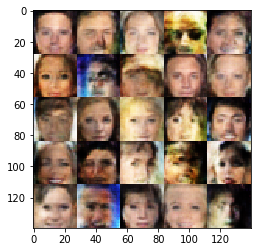

Epoch 1/1... Step 3410 Discriminator Loss: 1.0453... Generator Loss: 1.0927
Epoch 1/1... Step 3420 Discriminator Loss: 0.6537... Generator Loss: 1.6181
Epoch 1/1... Step 3430 Discriminator Loss: 0.8946... Generator Loss: 1.2084
Epoch 1/1... Step 3440 Discriminator Loss: 1.2935... Generator Loss: 0.6001
Epoch 1/1... Step 3450 Discriminator Loss: 1.3113... Generator Loss: 0.6517
Epoch 1/1... Step 3460 Discriminator Loss: 1.8837... Generator Loss: 0.2728
Epoch 1/1... Step 3470 Discriminator Loss: 1.1140... Generator Loss: 0.7582
Epoch 1/1... Step 3480 Discriminator Loss: 0.7583... Generator Loss: 1.6779
Epoch 1/1... Step 3490 Discriminator Loss: 0.7194... Generator Loss: 1.7195
Epoch 1/1... Step 3500 Discriminator Loss: 1.0288... Generator Loss: 1.6812


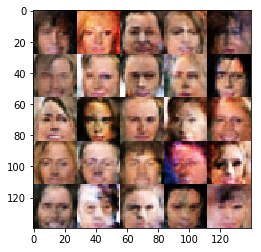

Epoch 1/1... Step 3510 Discriminator Loss: 1.1667... Generator Loss: 0.7604
Epoch 1/1... Step 3520 Discriminator Loss: 1.8902... Generator Loss: 2.3857
Epoch 1/1... Step 3530 Discriminator Loss: 1.1733... Generator Loss: 0.7699
Epoch 1/1... Step 3540 Discriminator Loss: 1.0538... Generator Loss: 0.8609
Epoch 1/1... Step 3550 Discriminator Loss: 1.3567... Generator Loss: 2.1273
Epoch 1/1... Step 3560 Discriminator Loss: 1.0976... Generator Loss: 1.0931
Epoch 1/1... Step 3570 Discriminator Loss: 0.9569... Generator Loss: 0.8689
Epoch 1/1... Step 3580 Discriminator Loss: 1.3600... Generator Loss: 0.5173
Epoch 1/1... Step 3590 Discriminator Loss: 0.7677... Generator Loss: 1.6388
Epoch 1/1... Step 3600 Discriminator Loss: 0.9013... Generator Loss: 1.1198


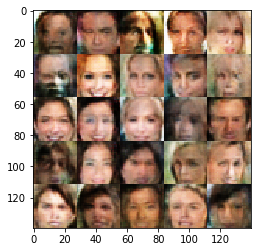

Epoch 1/1... Step 3610 Discriminator Loss: 0.8921... Generator Loss: 1.3711
Epoch 1/1... Step 3620 Discriminator Loss: 0.8163... Generator Loss: 1.1920
Epoch 1/1... Step 3630 Discriminator Loss: 1.1491... Generator Loss: 0.6425
Epoch 1/1... Step 3640 Discriminator Loss: 0.8739... Generator Loss: 1.0835
Epoch 1/1... Step 3650 Discriminator Loss: 1.2523... Generator Loss: 1.9624
Epoch 1/1... Step 3660 Discriminator Loss: 0.9371... Generator Loss: 1.0419
Epoch 1/1... Step 3670 Discriminator Loss: 1.3148... Generator Loss: 0.5328
Epoch 1/1... Step 3680 Discriminator Loss: 0.7640... Generator Loss: 1.2731
Epoch 1/1... Step 3690 Discriminator Loss: 1.1227... Generator Loss: 0.6974
Epoch 1/1... Step 3700 Discriminator Loss: 0.8571... Generator Loss: 1.2669


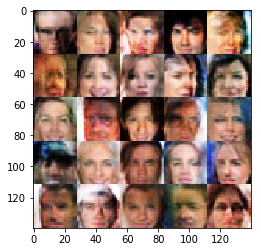

Epoch 1/1... Step 3710 Discriminator Loss: 1.3180... Generator Loss: 0.5919
Epoch 1/1... Step 3720 Discriminator Loss: 0.9451... Generator Loss: 2.0691
Epoch 1/1... Step 3730 Discriminator Loss: 1.1928... Generator Loss: 0.6551
Epoch 1/1... Step 3740 Discriminator Loss: 0.8081... Generator Loss: 1.9906
Epoch 1/1... Step 3750 Discriminator Loss: 1.5481... Generator Loss: 0.3897
Epoch 1/1... Step 3760 Discriminator Loss: 1.0343... Generator Loss: 0.7480
Epoch 1/1... Step 3770 Discriminator Loss: 0.5907... Generator Loss: 2.0722
Epoch 1/1... Step 3780 Discriminator Loss: 1.1804... Generator Loss: 0.6976
Epoch 1/1... Step 3790 Discriminator Loss: 1.1320... Generator Loss: 0.7611
Epoch 1/1... Step 3800 Discriminator Loss: 0.8252... Generator Loss: 2.1146


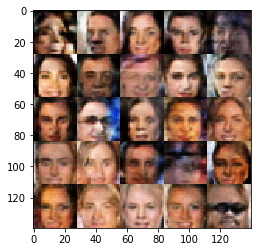

Epoch 1/1... Step 3810 Discriminator Loss: 0.9552... Generator Loss: 1.1221
Epoch 1/1... Step 3820 Discriminator Loss: 1.4041... Generator Loss: 0.5557
Epoch 1/1... Step 3830 Discriminator Loss: 1.2093... Generator Loss: 1.4199
Epoch 1/1... Step 3840 Discriminator Loss: 0.5268... Generator Loss: 2.0360
Epoch 1/1... Step 3850 Discriminator Loss: 0.8627... Generator Loss: 1.9621
Epoch 1/1... Step 3860 Discriminator Loss: 0.6760... Generator Loss: 1.4587
Epoch 1/1... Step 3870 Discriminator Loss: 1.2411... Generator Loss: 0.6007
Epoch 1/1... Step 3880 Discriminator Loss: 0.8853... Generator Loss: 1.0719
Epoch 1/1... Step 3890 Discriminator Loss: 0.7023... Generator Loss: 1.5927
Epoch 1/1... Step 3900 Discriminator Loss: 0.9015... Generator Loss: 0.9542


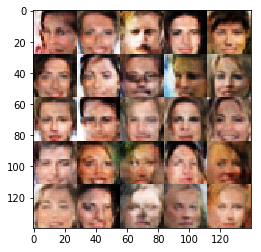

Epoch 1/1... Step 3910 Discriminator Loss: 1.1564... Generator Loss: 0.8065
Epoch 1/1... Step 3920 Discriminator Loss: 0.9138... Generator Loss: 1.1291
Epoch 1/1... Step 3930 Discriminator Loss: 0.9605... Generator Loss: 1.0932
Epoch 1/1... Step 3940 Discriminator Loss: 1.0134... Generator Loss: 2.2155
Epoch 1/1... Step 3950 Discriminator Loss: 0.7558... Generator Loss: 1.8659
Epoch 1/1... Step 3960 Discriminator Loss: 0.6159... Generator Loss: 1.7823
Epoch 1/1... Step 3970 Discriminator Loss: 0.5518... Generator Loss: 2.0502
Epoch 1/1... Step 3980 Discriminator Loss: 1.0635... Generator Loss: 1.6246
Epoch 1/1... Step 3990 Discriminator Loss: 1.0384... Generator Loss: 0.7066
Epoch 1/1... Step 4000 Discriminator Loss: 1.0893... Generator Loss: 0.7302


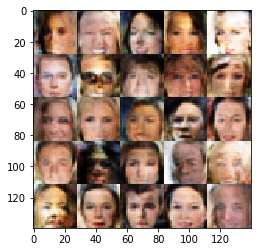

Epoch 1/1... Step 4010 Discriminator Loss: 0.7434... Generator Loss: 1.5423
Epoch 1/1... Step 4020 Discriminator Loss: 0.5524... Generator Loss: 3.2486
Epoch 1/1... Step 4030 Discriminator Loss: 0.8082... Generator Loss: 3.1859
Epoch 1/1... Step 4040 Discriminator Loss: 0.6427... Generator Loss: 1.6598
Epoch 1/1... Step 4050 Discriminator Loss: 0.8282... Generator Loss: 1.6897
Epoch 1/1... Step 4060 Discriminator Loss: 1.2141... Generator Loss: 0.6178
Epoch 1/1... Step 4070 Discriminator Loss: 0.7736... Generator Loss: 1.5507
Epoch 1/1... Step 4080 Discriminator Loss: 1.6896... Generator Loss: 0.3637
Epoch 1/1... Step 4090 Discriminator Loss: 1.2800... Generator Loss: 0.5720
Epoch 1/1... Step 4100 Discriminator Loss: 1.2241... Generator Loss: 1.2659


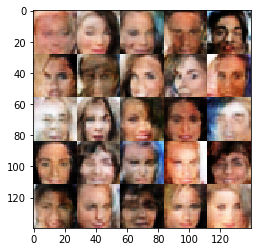

Epoch 1/1... Step 4110 Discriminator Loss: 1.6592... Generator Loss: 0.3740
Epoch 1/1... Step 4120 Discriminator Loss: 0.7570... Generator Loss: 3.0027
Epoch 1/1... Step 4130 Discriminator Loss: 0.5481... Generator Loss: 1.9723
Epoch 1/1... Step 4140 Discriminator Loss: 0.8905... Generator Loss: 1.2277
Epoch 1/1... Step 4150 Discriminator Loss: 1.6071... Generator Loss: 0.3989
Epoch 1/1... Step 4160 Discriminator Loss: 0.7115... Generator Loss: 2.7632
Epoch 1/1... Step 4170 Discriminator Loss: 1.3119... Generator Loss: 2.2397
Epoch 1/1... Step 4180 Discriminator Loss: 1.3815... Generator Loss: 0.5177
Epoch 1/1... Step 4190 Discriminator Loss: 1.4931... Generator Loss: 0.4406
Epoch 1/1... Step 4200 Discriminator Loss: 1.0123... Generator Loss: 0.7817


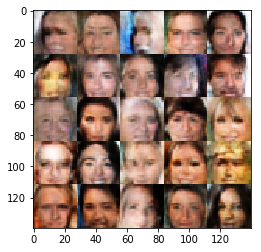

Epoch 1/1... Step 4210 Discriminator Loss: 0.7042... Generator Loss: 2.3372
Epoch 1/1... Step 4220 Discriminator Loss: 0.7518... Generator Loss: 3.1793
Epoch 1/1... Step 4230 Discriminator Loss: 0.8755... Generator Loss: 1.0074
Epoch 1/1... Step 4240 Discriminator Loss: 1.0869... Generator Loss: 2.3448
Epoch 1/1... Step 4250 Discriminator Loss: 0.8325... Generator Loss: 1.0836
Epoch 1/1... Step 4260 Discriminator Loss: 0.7775... Generator Loss: 2.2478
Epoch 1/1... Step 4270 Discriminator Loss: 0.8052... Generator Loss: 1.1494
Epoch 1/1... Step 4280 Discriminator Loss: 0.8025... Generator Loss: 1.2609
Epoch 1/1... Step 4290 Discriminator Loss: 0.6788... Generator Loss: 2.6762
Epoch 1/1... Step 4300 Discriminator Loss: 0.8755... Generator Loss: 1.0203


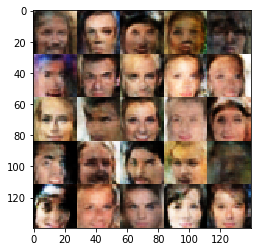

Epoch 1/1... Step 4310 Discriminator Loss: 0.9726... Generator Loss: 2.0402
Epoch 1/1... Step 4320 Discriminator Loss: 0.5503... Generator Loss: 2.0470
Epoch 1/1... Step 4330 Discriminator Loss: 0.7781... Generator Loss: 1.1887
Epoch 1/1... Step 4340 Discriminator Loss: 1.4979... Generator Loss: 0.4539
Epoch 1/1... Step 4350 Discriminator Loss: 0.7692... Generator Loss: 1.5514
Epoch 1/1... Step 4360 Discriminator Loss: 0.7462... Generator Loss: 2.6937
Epoch 1/1... Step 4370 Discriminator Loss: 1.4075... Generator Loss: 0.4923
Epoch 1/1... Step 4380 Discriminator Loss: 0.5837... Generator Loss: 2.8840
Epoch 1/1... Step 4390 Discriminator Loss: 1.7612... Generator Loss: 2.5310
Epoch 1/1... Step 4400 Discriminator Loss: 1.2309... Generator Loss: 2.2443


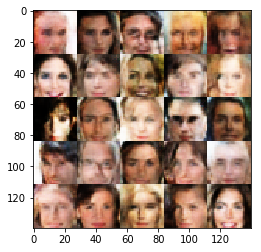

Epoch 1/1... Step 4410 Discriminator Loss: 0.7391... Generator Loss: 1.2578
Epoch 1/1... Step 4420 Discriminator Loss: 0.7316... Generator Loss: 1.2555
Epoch 1/1... Step 4430 Discriminator Loss: 0.8587... Generator Loss: 1.9755
Epoch 1/1... Step 4440 Discriminator Loss: 0.7374... Generator Loss: 1.2125
Epoch 1/1... Step 4450 Discriminator Loss: 0.5403... Generator Loss: 2.8194
Epoch 1/1... Step 4460 Discriminator Loss: 1.3644... Generator Loss: 4.1673
Epoch 1/1... Step 4470 Discriminator Loss: 1.0026... Generator Loss: 0.8299
Epoch 1/1... Step 4480 Discriminator Loss: 1.0488... Generator Loss: 0.8314
Epoch 1/1... Step 4490 Discriminator Loss: 0.7892... Generator Loss: 2.1794
Epoch 1/1... Step 4500 Discriminator Loss: 1.0701... Generator Loss: 0.7717


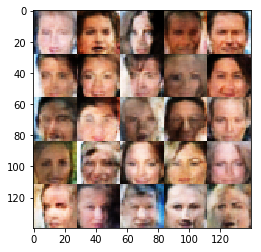

Epoch 1/1... Step 4510 Discriminator Loss: 0.7086... Generator Loss: 1.3506
Epoch 1/1... Step 4520 Discriminator Loss: 0.7456... Generator Loss: 1.2223
Epoch 1/1... Step 4530 Discriminator Loss: 1.4908... Generator Loss: 0.4718
Epoch 1/1... Step 4540 Discriminator Loss: 1.1320... Generator Loss: 0.7421
Epoch 1/1... Step 4550 Discriminator Loss: 0.8049... Generator Loss: 2.7497
Epoch 1/1... Step 4560 Discriminator Loss: 0.6534... Generator Loss: 1.8285
Epoch 1/1... Step 4570 Discriminator Loss: 0.6900... Generator Loss: 1.8111
Epoch 1/1... Step 4580 Discriminator Loss: 1.0868... Generator Loss: 2.9119
Epoch 1/1... Step 4590 Discriminator Loss: 0.8191... Generator Loss: 1.2962
Epoch 1/1... Step 4600 Discriminator Loss: 0.6164... Generator Loss: 1.8094


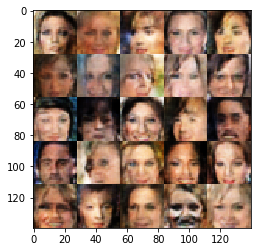

Epoch 1/1... Step 4610 Discriminator Loss: 0.7530... Generator Loss: 2.2772
Epoch 1/1... Step 4620 Discriminator Loss: 0.6670... Generator Loss: 1.5096
Epoch 1/1... Step 4630 Discriminator Loss: 0.7853... Generator Loss: 1.8522
Epoch 1/1... Step 4640 Discriminator Loss: 1.0944... Generator Loss: 0.7320
Epoch 1/1... Step 4650 Discriminator Loss: 1.1190... Generator Loss: 0.7002
Epoch 1/1... Step 4660 Discriminator Loss: 0.8229... Generator Loss: 1.0573
Epoch 1/1... Step 4670 Discriminator Loss: 1.1555... Generator Loss: 0.7573
Epoch 1/1... Step 4680 Discriminator Loss: 0.9280... Generator Loss: 1.3799
Epoch 1/1... Step 4690 Discriminator Loss: 0.5712... Generator Loss: 2.0607
Epoch 1/1... Step 4700 Discriminator Loss: 0.5338... Generator Loss: 2.4308


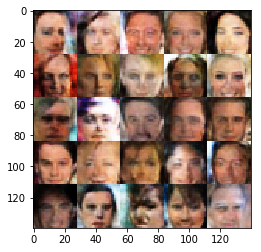

Epoch 1/1... Step 4710 Discriminator Loss: 1.0773... Generator Loss: 0.7190
Epoch 1/1... Step 4720 Discriminator Loss: 0.4441... Generator Loss: 2.8151
Epoch 1/1... Step 4730 Discriminator Loss: 1.0327... Generator Loss: 0.7955
Epoch 1/1... Step 4740 Discriminator Loss: 0.7216... Generator Loss: 1.6558
Epoch 1/1... Step 4750 Discriminator Loss: 1.1351... Generator Loss: 1.9224
Epoch 1/1... Step 4760 Discriminator Loss: 0.6696... Generator Loss: 2.2677
Epoch 1/1... Step 4770 Discriminator Loss: 0.6316... Generator Loss: 1.5626
Epoch 1/1... Step 4780 Discriminator Loss: 1.0444... Generator Loss: 0.7335
Epoch 1/1... Step 4790 Discriminator Loss: 0.8005... Generator Loss: 1.1142
Epoch 1/1... Step 4800 Discriminator Loss: 0.5248... Generator Loss: 3.0736


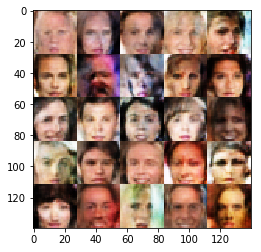

Epoch 1/1... Step 4810 Discriminator Loss: 0.6438... Generator Loss: 2.4634
Epoch 1/1... Step 4820 Discriminator Loss: 1.8370... Generator Loss: 0.3191
Epoch 1/1... Step 4830 Discriminator Loss: 0.7094... Generator Loss: 1.4285
Epoch 1/1... Step 4840 Discriminator Loss: 0.6448... Generator Loss: 1.4526
Epoch 1/1... Step 4850 Discriminator Loss: 0.6452... Generator Loss: 1.7661
Epoch 1/1... Step 4860 Discriminator Loss: 0.6063... Generator Loss: 1.9796
Epoch 1/1... Step 4870 Discriminator Loss: 0.8843... Generator Loss: 2.2619
Epoch 1/1... Step 4880 Discriminator Loss: 0.5378... Generator Loss: 2.4685
Epoch 1/1... Step 4890 Discriminator Loss: 2.3920... Generator Loss: 0.1822
Epoch 1/1... Step 4900 Discriminator Loss: 1.0678... Generator Loss: 2.3660


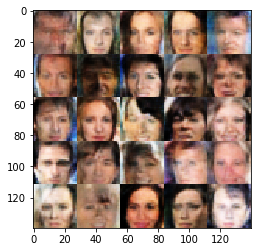

Epoch 1/1... Step 4910 Discriminator Loss: 1.1401... Generator Loss: 0.6570
Epoch 1/1... Step 4920 Discriminator Loss: 0.7137... Generator Loss: 3.0191
Epoch 1/1... Step 4930 Discriminator Loss: 0.5669... Generator Loss: 1.8688
Epoch 1/1... Step 4940 Discriminator Loss: 0.4577... Generator Loss: 2.7577
Epoch 1/1... Step 4950 Discriminator Loss: 0.4422... Generator Loss: 2.7042
Epoch 1/1... Step 4960 Discriminator Loss: 0.8498... Generator Loss: 0.9851
Epoch 1/1... Step 4970 Discriminator Loss: 0.8562... Generator Loss: 0.9790
Epoch 1/1... Step 4980 Discriminator Loss: 0.5800... Generator Loss: 2.3935
Epoch 1/1... Step 4990 Discriminator Loss: 0.7668... Generator Loss: 1.2576
Epoch 1/1... Step 5000 Discriminator Loss: 0.6833... Generator Loss: 2.3345


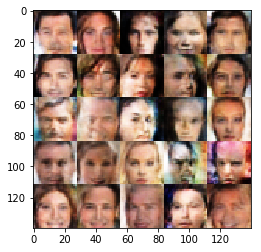

Epoch 1/1... Step 5010 Discriminator Loss: 0.4478... Generator Loss: 3.6634
Epoch 1/1... Step 5020 Discriminator Loss: 0.7762... Generator Loss: 3.1876
Epoch 1/1... Step 5030 Discriminator Loss: 1.8455... Generator Loss: 2.4688
Epoch 1/1... Step 5040 Discriminator Loss: 0.7131... Generator Loss: 1.3127
Epoch 1/1... Step 5050 Discriminator Loss: 0.6734... Generator Loss: 1.4515
Epoch 1/1... Step 5060 Discriminator Loss: 1.1440... Generator Loss: 2.7768
Epoch 1/1... Step 5070 Discriminator Loss: 1.1556... Generator Loss: 0.6621
Epoch 1/1... Step 5080 Discriminator Loss: 0.7613... Generator Loss: 1.4241
Epoch 1/1... Step 5090 Discriminator Loss: 0.7682... Generator Loss: 1.8189
Epoch 1/1... Step 5100 Discriminator Loss: 0.5432... Generator Loss: 1.8775


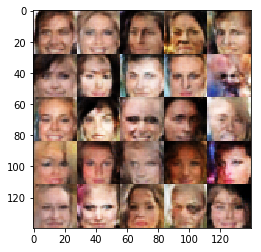

Epoch 1/1... Step 5110 Discriminator Loss: 1.6251... Generator Loss: 0.3957
Epoch 1/1... Step 5120 Discriminator Loss: 0.7351... Generator Loss: 1.2267
Epoch 1/1... Step 5130 Discriminator Loss: 0.8160... Generator Loss: 2.7521
Epoch 1/1... Step 5140 Discriminator Loss: 0.6751... Generator Loss: 1.4601
Epoch 1/1... Step 5150 Discriminator Loss: 0.7662... Generator Loss: 3.2370
Epoch 1/1... Step 5160 Discriminator Loss: 0.4629... Generator Loss: 2.6072
Epoch 1/1... Step 5170 Discriminator Loss: 1.7486... Generator Loss: 2.6104
Epoch 1/1... Step 5180 Discriminator Loss: 0.5488... Generator Loss: 2.6777
Epoch 1/1... Step 5190 Discriminator Loss: 0.7381... Generator Loss: 1.2133
Epoch 1/1... Step 5200 Discriminator Loss: 0.8349... Generator Loss: 1.5805


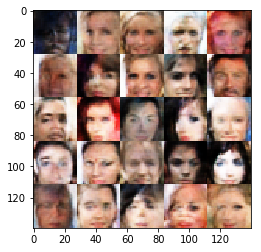

Epoch 1/1... Step 5210 Discriminator Loss: 1.5039... Generator Loss: 0.4451
Epoch 1/1... Step 5220 Discriminator Loss: 0.5983... Generator Loss: 1.8509
Epoch 1/1... Step 5230 Discriminator Loss: 0.5405... Generator Loss: 2.1208
Epoch 1/1... Step 5240 Discriminator Loss: 0.5425... Generator Loss: 2.3515
Epoch 1/1... Step 5250 Discriminator Loss: 0.4986... Generator Loss: 2.6414
Epoch 1/1... Step 5260 Discriminator Loss: 0.8912... Generator Loss: 3.2550
Epoch 1/1... Step 5270 Discriminator Loss: 0.6639... Generator Loss: 2.7837
Epoch 1/1... Step 5280 Discriminator Loss: 0.7813... Generator Loss: 1.2192
Epoch 1/1... Step 5290 Discriminator Loss: 1.9839... Generator Loss: 4.3395
Epoch 1/1... Step 5300 Discriminator Loss: 1.4047... Generator Loss: 1.7572


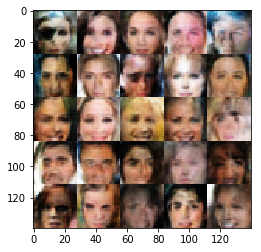

Epoch 1/1... Step 5310 Discriminator Loss: 0.7549... Generator Loss: 1.2259
Epoch 1/1... Step 5320 Discriminator Loss: 0.5930... Generator Loss: 1.6597
Epoch 1/1... Step 5330 Discriminator Loss: 0.6135... Generator Loss: 1.5566
Epoch 1/1... Step 5340 Discriminator Loss: 0.8125... Generator Loss: 3.9097
Epoch 1/1... Step 5350 Discriminator Loss: 1.6354... Generator Loss: 2.2320
Epoch 1/1... Step 5360 Discriminator Loss: 0.6643... Generator Loss: 1.8639
Epoch 1/1... Step 5370 Discriminator Loss: 1.1299... Generator Loss: 0.7754
Epoch 1/1... Step 5380 Discriminator Loss: 1.1143... Generator Loss: 0.7501
Epoch 1/1... Step 5390 Discriminator Loss: 0.6564... Generator Loss: 1.5577
Epoch 1/1... Step 5400 Discriminator Loss: 1.6301... Generator Loss: 3.3311


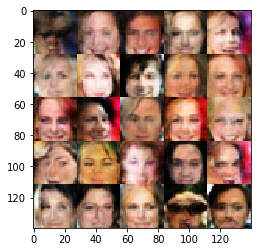

Epoch 1/1... Step 5410 Discriminator Loss: 0.9704... Generator Loss: 0.8784
Epoch 1/1... Step 5420 Discriminator Loss: 0.6238... Generator Loss: 1.6643
Epoch 1/1... Step 5430 Discriminator Loss: 1.3424... Generator Loss: 3.2346
Epoch 1/1... Step 5440 Discriminator Loss: 0.5379... Generator Loss: 2.5367
Epoch 1/1... Step 5450 Discriminator Loss: 1.3918... Generator Loss: 0.5223
Epoch 1/1... Step 5460 Discriminator Loss: 0.7820... Generator Loss: 2.1859
Epoch 1/1... Step 5470 Discriminator Loss: 0.4714... Generator Loss: 2.3688
Epoch 1/1... Step 5480 Discriminator Loss: 0.9871... Generator Loss: 0.8734
Epoch 1/1... Step 5490 Discriminator Loss: 0.8029... Generator Loss: 1.1860
Epoch 1/1... Step 5500 Discriminator Loss: 1.8659... Generator Loss: 2.8542


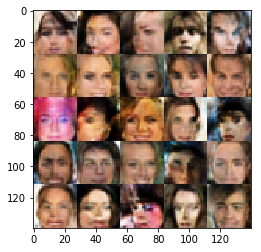

Epoch 1/1... Step 5510 Discriminator Loss: 0.5305... Generator Loss: 1.9342
Epoch 1/1... Step 5520 Discriminator Loss: 0.4822... Generator Loss: 2.3333
Epoch 1/1... Step 5530 Discriminator Loss: 0.5419... Generator Loss: 2.8565
Epoch 1/1... Step 5540 Discriminator Loss: 0.6733... Generator Loss: 2.1155
Epoch 1/1... Step 5550 Discriminator Loss: 0.5961... Generator Loss: 1.7455
Epoch 1/1... Step 5560 Discriminator Loss: 0.5410... Generator Loss: 1.8897
Epoch 1/1... Step 5570 Discriminator Loss: 0.8184... Generator Loss: 2.9670
Epoch 1/1... Step 5580 Discriminator Loss: 1.4528... Generator Loss: 3.0721
Epoch 1/1... Step 5590 Discriminator Loss: 0.4832... Generator Loss: 2.5868
Epoch 1/1... Step 5600 Discriminator Loss: 0.8749... Generator Loss: 3.8406


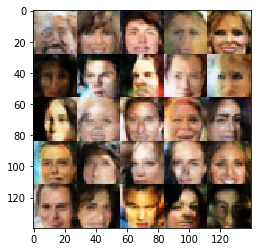

Epoch 1/1... Step 5610 Discriminator Loss: 0.8859... Generator Loss: 1.0182
Epoch 1/1... Step 5620 Discriminator Loss: 0.4586... Generator Loss: 2.4421
Epoch 1/1... Step 5630 Discriminator Loss: 0.6411... Generator Loss: 4.1276
Epoch 1/1... Step 5640 Discriminator Loss: 0.5831... Generator Loss: 1.8693
Epoch 1/1... Step 5650 Discriminator Loss: 0.5673... Generator Loss: 2.3525
Epoch 1/1... Step 5660 Discriminator Loss: 1.1699... Generator Loss: 2.5617
Epoch 1/1... Step 5670 Discriminator Loss: 0.4408... Generator Loss: 2.5195
Epoch 1/1... Step 5680 Discriminator Loss: 0.4200... Generator Loss: 2.8041
Epoch 1/1... Step 5690 Discriminator Loss: 0.5293... Generator Loss: 2.6602
Epoch 1/1... Step 5700 Discriminator Loss: 0.4558... Generator Loss: 2.9722


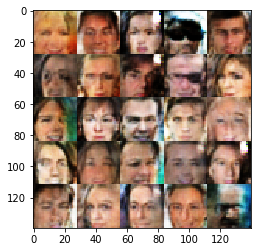

Epoch 1/1... Step 5710 Discriminator Loss: 0.5301... Generator Loss: 2.0710
Epoch 1/1... Step 5720 Discriminator Loss: 0.7537... Generator Loss: 2.9336
Epoch 1/1... Step 5730 Discriminator Loss: 0.9176... Generator Loss: 1.3398
Epoch 1/1... Step 5740 Discriminator Loss: 0.5752... Generator Loss: 1.9712
Epoch 1/1... Step 5750 Discriminator Loss: 1.2168... Generator Loss: 0.7690
Epoch 1/1... Step 5760 Discriminator Loss: 0.8688... Generator Loss: 2.6198
Epoch 1/1... Step 5770 Discriminator Loss: 0.8956... Generator Loss: 3.9665
Epoch 1/1... Step 5780 Discriminator Loss: 0.5253... Generator Loss: 1.9182
Epoch 1/1... Step 5790 Discriminator Loss: 0.4847... Generator Loss: 2.6329
Epoch 1/1... Step 5800 Discriminator Loss: 0.6013... Generator Loss: 1.6239


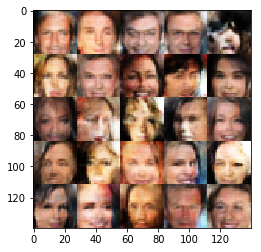

Epoch 1/1... Step 5810 Discriminator Loss: 0.7822... Generator Loss: 2.9299
Epoch 1/1... Step 5820 Discriminator Loss: 0.7864... Generator Loss: 1.3184
Epoch 1/1... Step 5830 Discriminator Loss: 0.9139... Generator Loss: 3.3762
Epoch 1/1... Step 5840 Discriminator Loss: 0.7333... Generator Loss: 1.3575
Epoch 1/1... Step 5850 Discriminator Loss: 0.5562... Generator Loss: 5.0245
Epoch 1/1... Step 5860 Discriminator Loss: 0.3920... Generator Loss: 3.4778
Epoch 1/1... Step 5870 Discriminator Loss: 0.6641... Generator Loss: 1.4538
Epoch 1/1... Step 5880 Discriminator Loss: 2.0510... Generator Loss: 0.2892
Epoch 1/1... Step 5890 Discriminator Loss: 0.6311... Generator Loss: 1.4603
Epoch 1/1... Step 5900 Discriminator Loss: 0.4093... Generator Loss: 2.9940


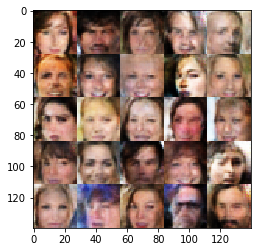

Epoch 1/1... Step 5910 Discriminator Loss: 0.6912... Generator Loss: 1.4065
Epoch 1/1... Step 5920 Discriminator Loss: 0.5667... Generator Loss: 1.9737
Epoch 1/1... Step 5930 Discriminator Loss: 0.5435... Generator Loss: 2.4190
Epoch 1/1... Step 5940 Discriminator Loss: 0.6402... Generator Loss: 2.9316
Epoch 1/1... Step 5950 Discriminator Loss: 1.1215... Generator Loss: 0.7464
Epoch 1/1... Step 5960 Discriminator Loss: 1.4337... Generator Loss: 0.4896
Epoch 1/1... Step 5970 Discriminator Loss: 0.5074... Generator Loss: 2.0672
Epoch 1/1... Step 5980 Discriminator Loss: 0.6652... Generator Loss: 1.7645
Epoch 1/1... Step 5990 Discriminator Loss: 0.5738... Generator Loss: 1.7375
Epoch 1/1... Step 6000 Discriminator Loss: 0.4680... Generator Loss: 2.8696


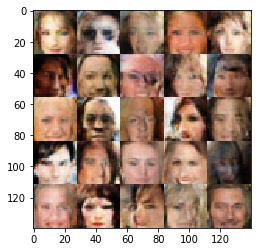

Epoch 1/1... Step 6010 Discriminator Loss: 0.4521... Generator Loss: 2.8013
Epoch 1/1... Step 6020 Discriminator Loss: 1.1243... Generator Loss: 4.3312
Epoch 1/1... Step 6030 Discriminator Loss: 0.9215... Generator Loss: 1.8813
Epoch 1/1... Step 6040 Discriminator Loss: 0.4240... Generator Loss: 2.6301
Epoch 1/1... Step 6050 Discriminator Loss: 0.9479... Generator Loss: 1.0389
Epoch 1/1... Step 6060 Discriminator Loss: 0.4442... Generator Loss: 2.5564
Epoch 1/1... Step 6070 Discriminator Loss: 0.5384... Generator Loss: 2.0318
Epoch 1/1... Step 6080 Discriminator Loss: 0.4667... Generator Loss: 3.0931
Epoch 1/1... Step 6090 Discriminator Loss: 0.5789... Generator Loss: 2.1149
Epoch 1/1... Step 6100 Discriminator Loss: 0.5939... Generator Loss: 1.7415


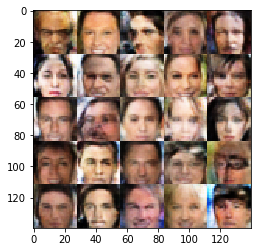

Epoch 1/1... Step 6110 Discriminator Loss: 0.5277... Generator Loss: 4.1073
Epoch 1/1... Step 6120 Discriminator Loss: 0.5232... Generator Loss: 1.9626
Epoch 1/1... Step 6130 Discriminator Loss: 0.4214... Generator Loss: 2.8400
Epoch 1/1... Step 6140 Discriminator Loss: 0.5240... Generator Loss: 2.3011
Epoch 1/1... Step 6150 Discriminator Loss: 0.6930... Generator Loss: 1.9469
Epoch 1/1... Step 6160 Discriminator Loss: 0.9562... Generator Loss: 1.3527
Epoch 1/1... Step 6170 Discriminator Loss: 0.8304... Generator Loss: 1.0562
Epoch 1/1... Step 6180 Discriminator Loss: 0.4559... Generator Loss: 2.3067
Epoch 1/1... Step 6190 Discriminator Loss: 0.5786... Generator Loss: 1.8570
Epoch 1/1... Step 6200 Discriminator Loss: 0.3928... Generator Loss: 3.2263


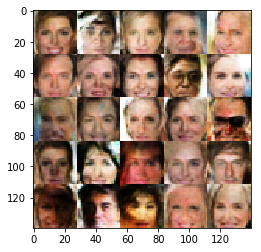

Epoch 1/1... Step 6210 Discriminator Loss: 2.9497... Generator Loss: 3.9687
Epoch 1/1... Step 6220 Discriminator Loss: 1.8993... Generator Loss: 2.6443
Epoch 1/1... Step 6230 Discriminator Loss: 1.0903... Generator Loss: 0.7819
Epoch 1/1... Step 6240 Discriminator Loss: 0.6223... Generator Loss: 3.9098
Epoch 1/1... Step 6250 Discriminator Loss: 0.6201... Generator Loss: 2.4354
Epoch 1/1... Step 6260 Discriminator Loss: 0.4880... Generator Loss: 2.4465
Epoch 1/1... Step 6270 Discriminator Loss: 1.0604... Generator Loss: 0.7831
Epoch 1/1... Step 6280 Discriminator Loss: 0.4286... Generator Loss: 2.7025
Epoch 1/1... Step 6290 Discriminator Loss: 0.4017... Generator Loss: 3.5706
Epoch 1/1... Step 6300 Discriminator Loss: 0.8603... Generator Loss: 1.2173


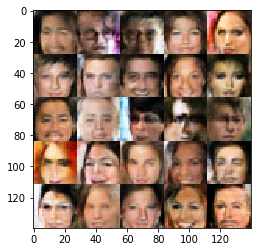

Epoch 1/1... Step 6310 Discriminator Loss: 0.5617... Generator Loss: 2.4951
Epoch 1/1... Step 6320 Discriminator Loss: 0.4709... Generator Loss: 3.3095
Epoch 1/1... Step 6330 Discriminator Loss: 0.8087... Generator Loss: 1.1507


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.